# Deconvolution R2921, 50 waveforms examined

Deconvolution of Kripton data

In [133]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
import Core.system_of_units as units
import tables
import Core.mplFunctions as mpl
import Core.wfmFunctions as wfm

In [135]:
import Sierpe.FEE as FE

In [136]:
from scipy import signal

In [137]:
import time

In [138]:
import pandas as pd

In [139]:
from Core.coreFunctions import wait

In [140]:
from Database import loadDB

In [141]:
import ICython.Sierpe.cBLR as cblr

## Revised on:

In [142]:
print(time.strftime("%d/%m/%Y"))

21/11/2016


In [143]:
print(time.strftime("%H:%M:%S"))

14:52:36


In [144]:
yield_factor = 574./690.
print('Yield factor (MC to NEW running conditions, November, 2016 = {})'.format(yield_factor))

Yield factor (MC to NEW running conditions, November, 2016 = 0.831884057971)


#### List the files

In [145]:
ls /Users/jjgomezcadenas/Documents/Development/NEXT/icdata

CalibElectrons/ CalibMC/        IC/             LSC/


In [146]:
pathmc='/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/CalibMC/'
pathel='/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/CalibElectrons/'
pathlsc='/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/LSC/'

In [147]:
ls '/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/LSC/run2921'

run_2921.gdc1next.000.next1el_2921.root.h5


In [148]:
r2921 = tables.open_file(pathlsc+'/run2921/run_2921.gdc1next.000.next1el_2921.root.h5','r+')

In [149]:
r2921

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/LSC//run2921/run_2921.gdc1next.000.next1el_2921.root.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/RD (Group) ''
/RD/pmtacum (EArray(91, 12, 48000)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 48000)
/RD/pmtblr (EArray(91, 12, 48000), zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/RD/pmtcwf (EArray(91, 12, 48000)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 48000)
/RD/pmtrwf (EArray(91, 12, 48000), zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/RD/sipmrwf (EArray(91, 1792, 1200

In [19]:
DataPMT = loadDB.DataPMT()

In [20]:
DataPMT

channel pmtid  active           x           y   coeff_c  coeff_blr  \
0         0     1       1  -23.941401   65.778503  0.000003   0.001632   
1        18     3       1  -44.995098  -53.623100  0.000003   0.001632   
2         1     2       1   68.936501  -12.155400  0.000003   0.001611   
3        19     4       1    0.000000  185.000000  0.000003   0.001599   
4        27     C       1 -118.916000  141.718002  0.000003   0.001567   
5        26     B       1 -182.188995   32.124901  0.000004   0.001650   
6         9     A       1 -160.214996  -92.500000  0.000003   0.001593   
7         8     9       1  -63.273701 -173.843002  0.000003   0.001612   
8        23     8       1   63.273701 -173.843002  0.000003   0.001601   
9        22     7       1  160.214996  -92.500000  0.000003   0.001593   
10        5     6       1  182.188995   32.124901  0.000003   0.001575   
11        4     5       1  118.916000  141.718002  0.000003   0.001596   

    adc_to_pes  noise_rms  
0     -22.9168     0.7060  
1     -23.7510     0.8744  
2     -25.3008     0.7213  
3     -25.9984     0.7624  
4     -23.7074     0.7921  
5     -20.8927     0.8660  
6     -22.1340     0.7062  
7     -33.0993     0.7278  
8     -20.4377     0.7303  
9     -25.1698     0.7160  
10    -15.8557     0.7323  
11    -18.2130     0.7206

## Testing new deconvolution with r2921 (Na-22, taken 17-11-2016) 

In [47]:
def deconv_cpmt(pmtrwf, event=0, thr_trigger=5,thr_acum=2000, 
                                 acum_discharge_length = 5000, 
                                 acum_tau=2500, 
                                 acum_compress=0.01):
    """
    Deconvolution of all the PMTs in the event cython function
    """
    NPMT = pmtrwf.shape[1]
    CWF = {}
    ACUM = {}
    for pmt in range(NPMT):
        signal_r, acum = cblr.deconvolve_signal_acum(pmtrwf[event,pmt], n_baseline=500, 
                                 coef_clean=DataPMT.coeff_c[pmt], 
                                 coef_blr=DataPMT.coeff_blr[pmt], 
                                 thr_trigger=thr_trigger, thr_acum=thr_acum, 
                                 acum_discharge_length = acum_discharge_length, 
                                 acum_tau=acum_tau, 
                                 acum_compress=acum_compress)
        CWF[pmt] = signal_r
        ACUM[pmt] = acum
    return pd.DataFrame(CWF), pd.DataFrame(ACUM)

In [21]:
pmtcwf = r2921.root.RD.pmtcwf

In [43]:
pmtacum = r2921.root.RD.pmtacum

In [156]:
pmtrwf = r2921.root.RD.pmtrwf

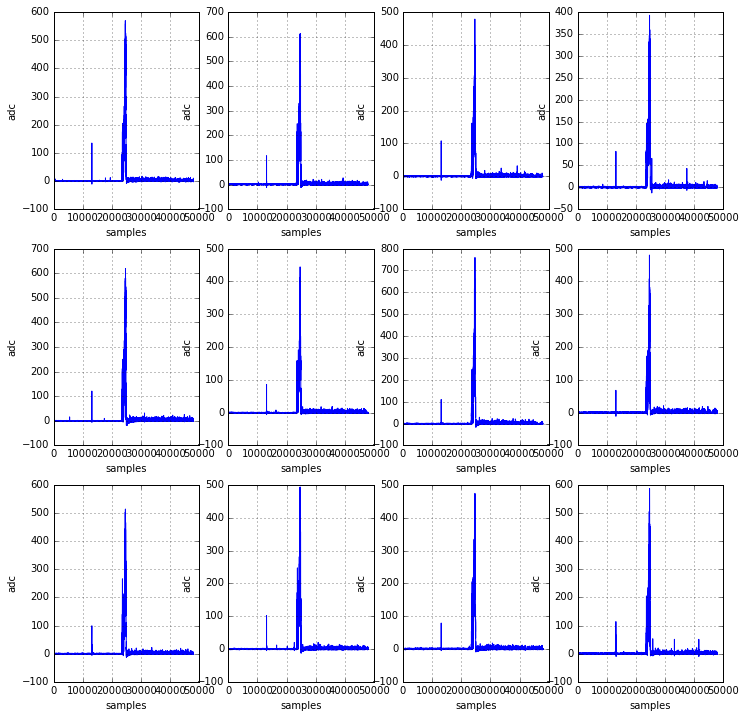

In [22]:
mpl.plot_waveforms(pmtcwf[0], maxlen=0, zoom=False, window_size=800)

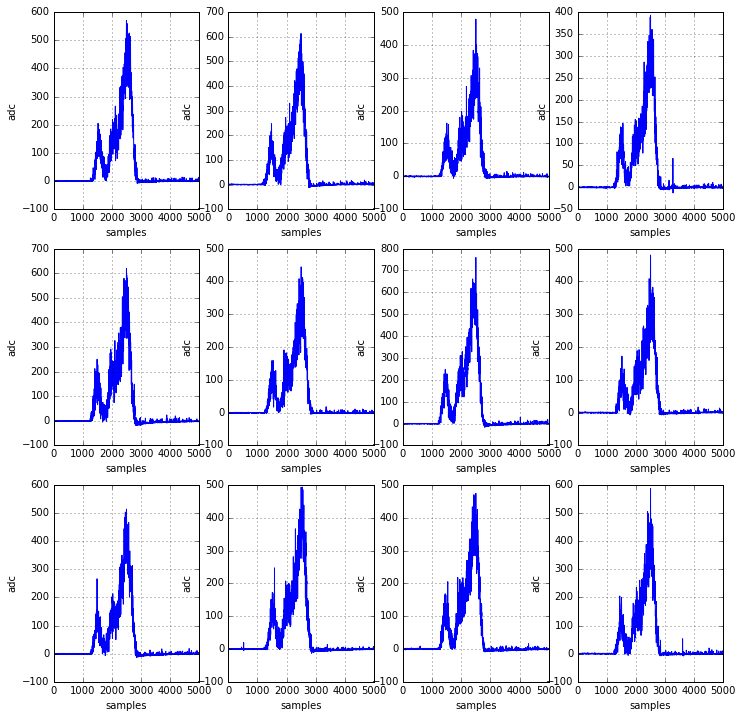

In [26]:
mpl.plot_waveforms(pmtcwf[0], maxlen=0, zoom=True, window_size=2500)

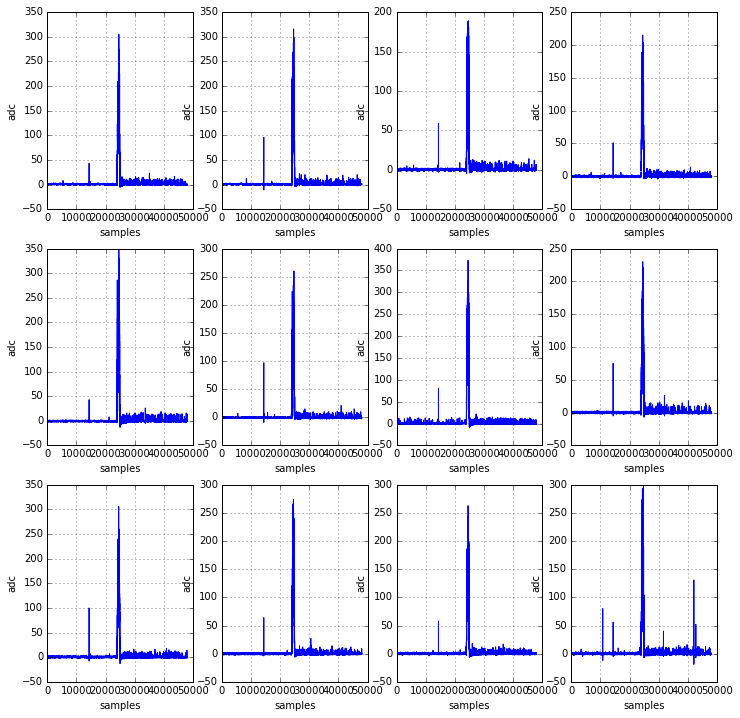

In [23]:
mpl.plot_waveforms(pmtcwf[1], maxlen=0, zoom=False, window_size=800)

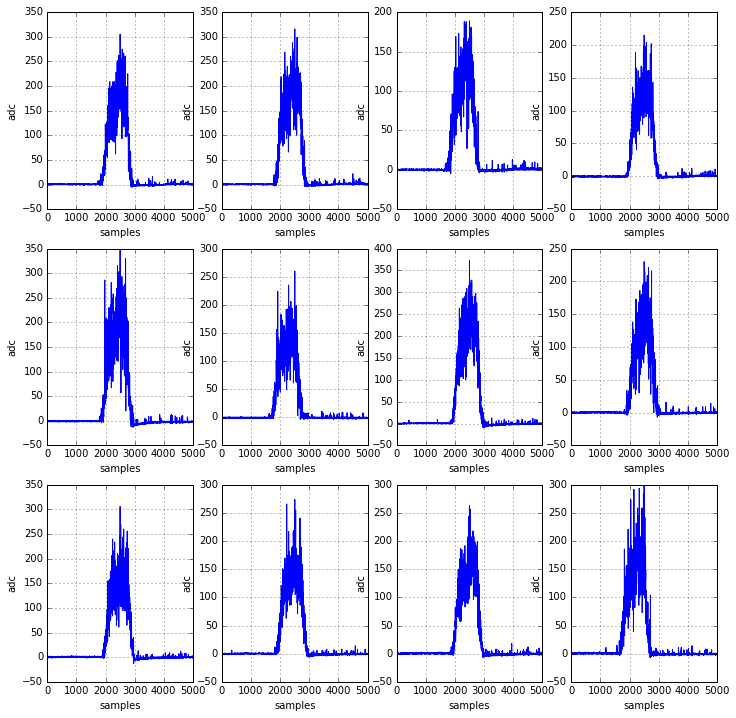

In [27]:
mpl.plot_waveforms(pmtcwf[1], maxlen=0, zoom=True, window_size=2500)

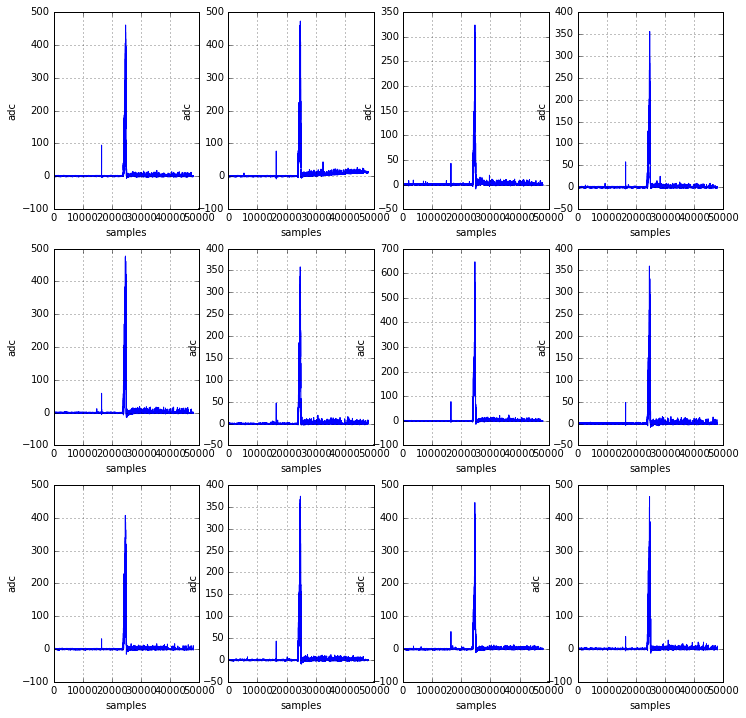

In [28]:
mpl.plot_waveforms(pmtcwf[2], maxlen=0, zoom=False, window_size=2500)

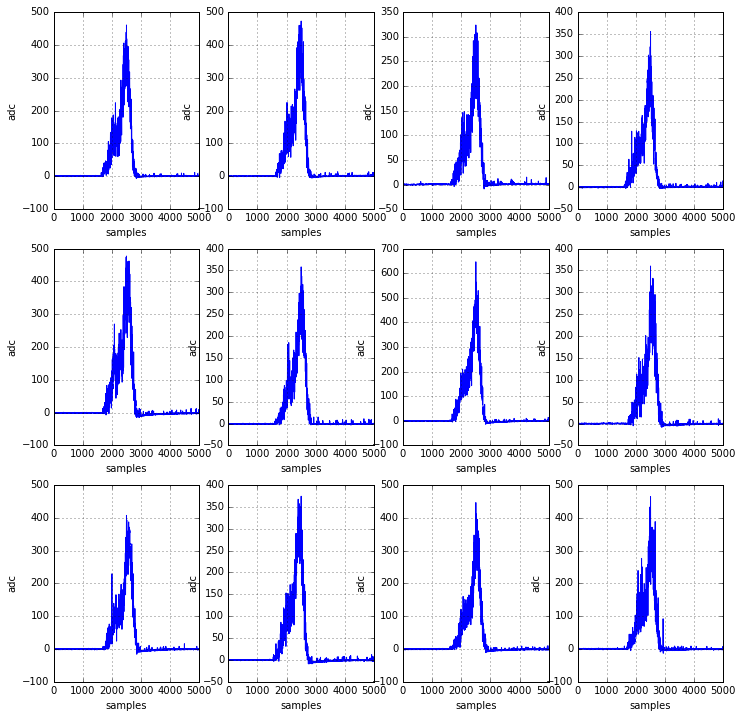

In [29]:
mpl.plot_waveforms(pmtcwf[2], maxlen=0, zoom=True, window_size=2500)

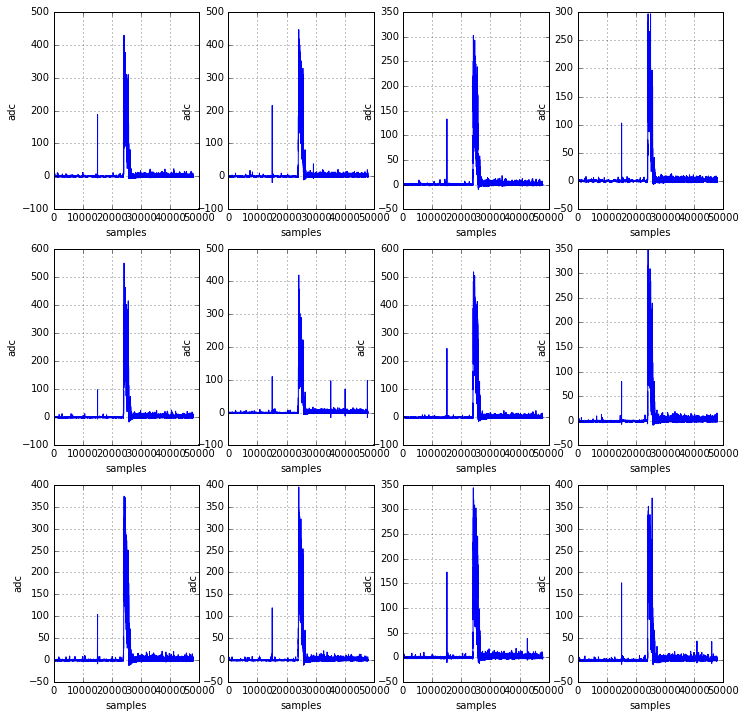

In [30]:
mpl.plot_waveforms(pmtcwf[3], maxlen=0, zoom=False, window_size=2500)

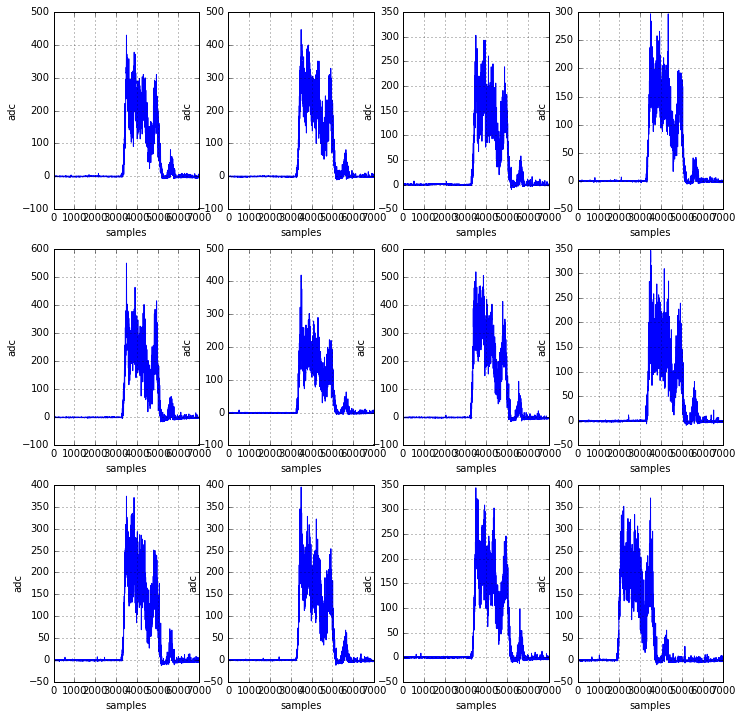

In [33]:
mpl.plot_waveforms(pmtcwf[3], maxlen=0, zoom=True, window_size=3500)

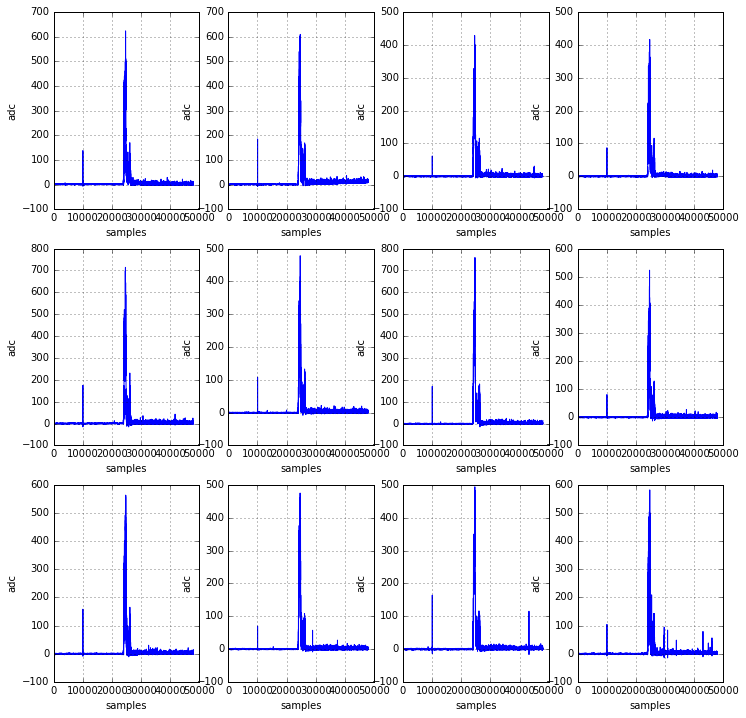

In [34]:
mpl.plot_waveforms(pmtcwf[4], maxlen=0, zoom=False, window_size=2500)

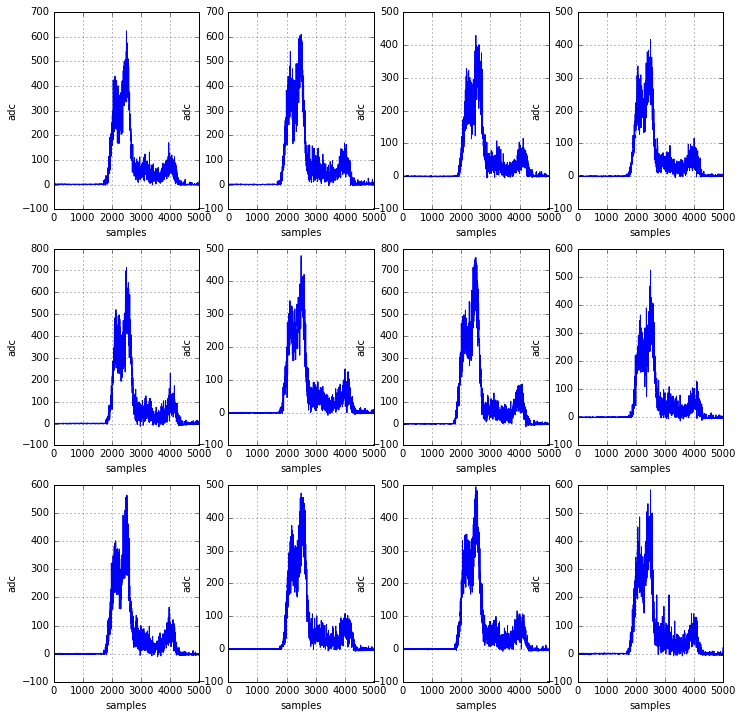

In [35]:
mpl.plot_waveforms(pmtcwf[4], maxlen=0, zoom=True, window_size=2500)

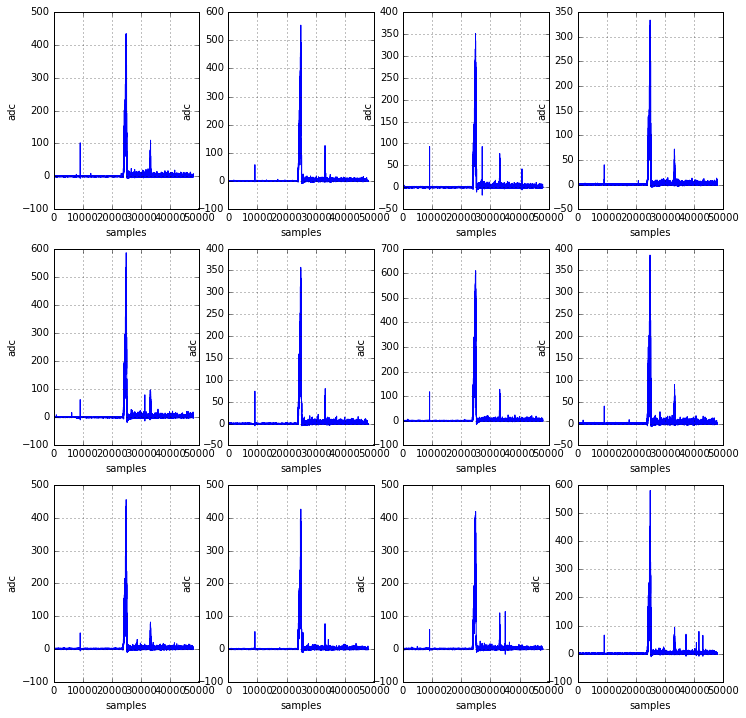

In [36]:
mpl.plot_waveforms(pmtcwf[5], maxlen=0, zoom=False, window_size=2500)

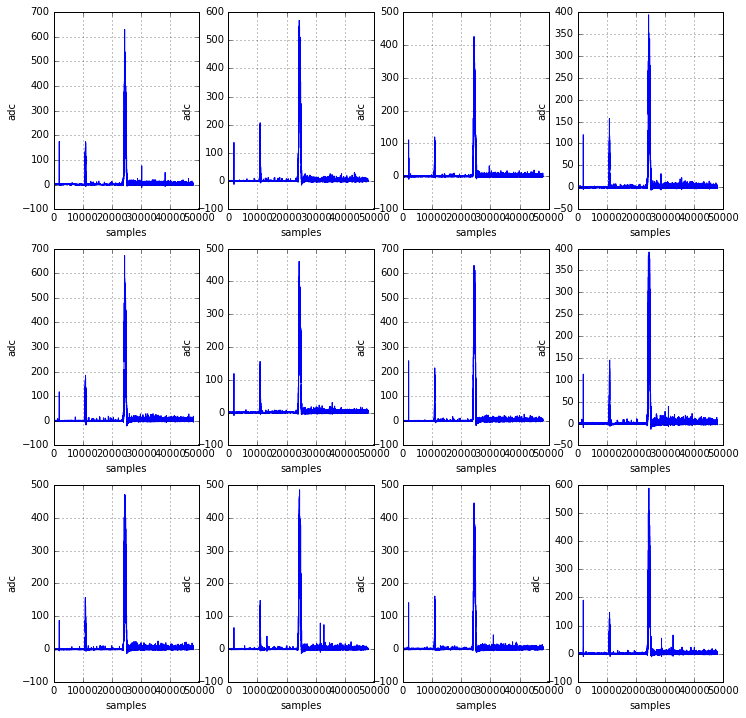

In [37]:
mpl.plot_waveforms(pmtcwf[6], maxlen=0, zoom=False, window_size=2500)

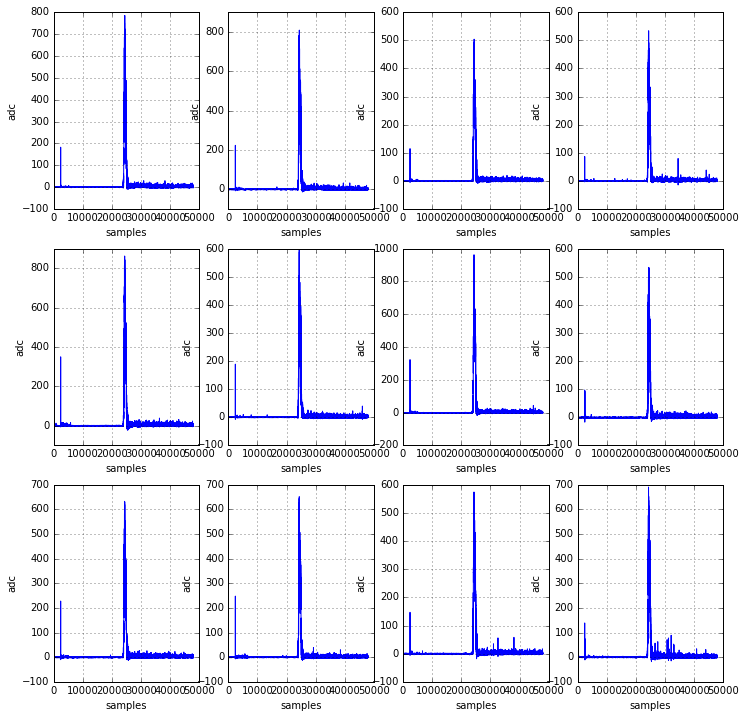

In [38]:
mpl.plot_waveforms(pmtcwf[7], maxlen=0, zoom=False, window_size=2500)

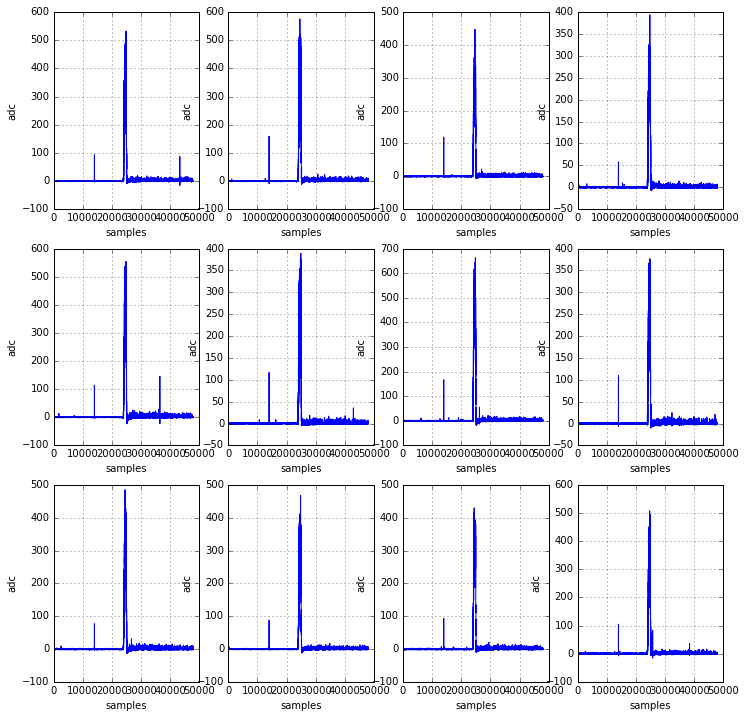

In [39]:
mpl.plot_waveforms(pmtcwf[8], maxlen=0, zoom=False, window_size=2500)

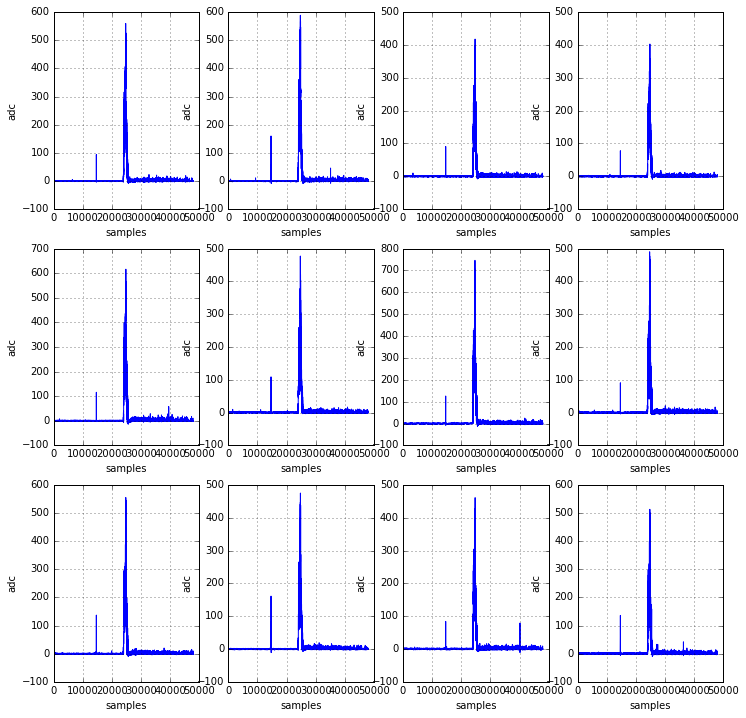

In [40]:
mpl.plot_waveforms(pmtcwf[9], maxlen=0, zoom=False, window_size=2500)

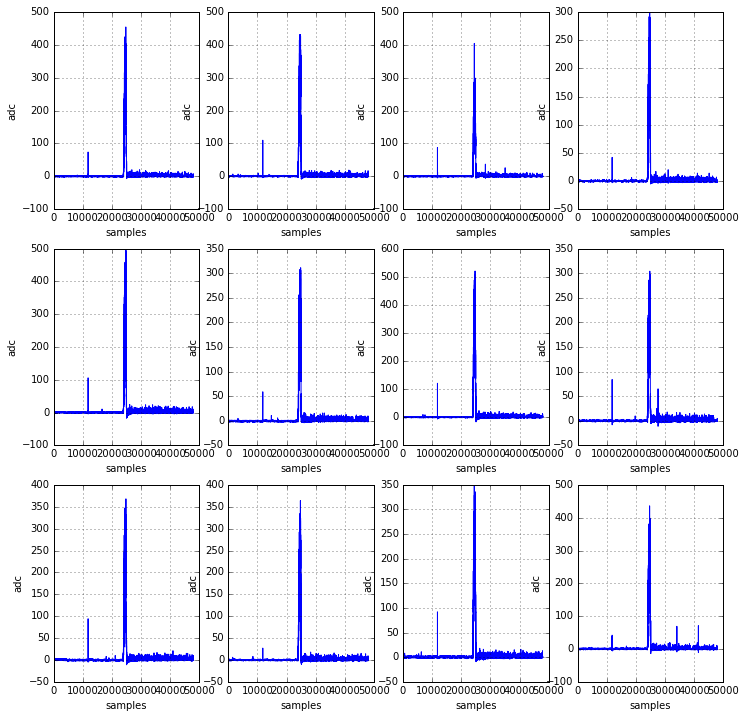

In [41]:
mpl.plot_waveforms(pmtcwf[10], maxlen=0, zoom=False, window_size=2500)

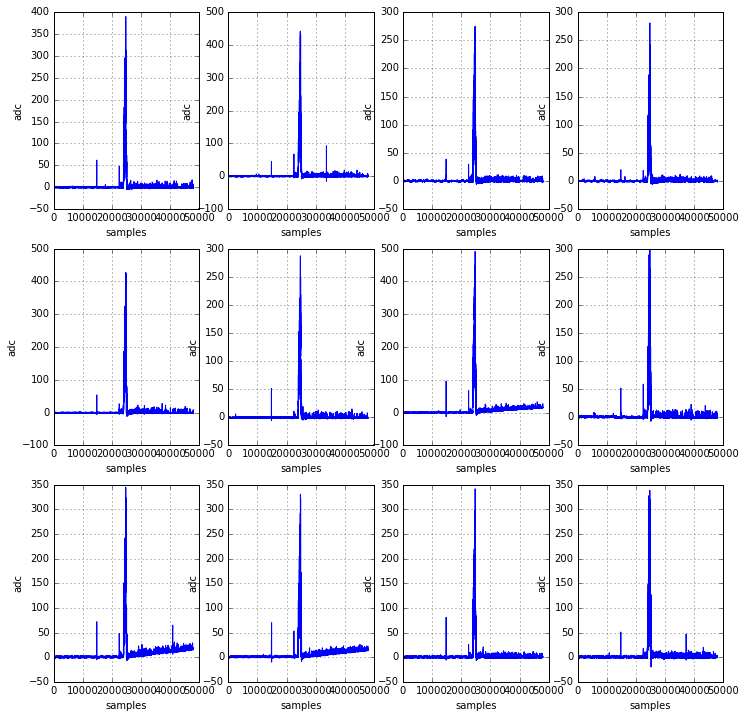

In [42]:
mpl.plot_waveforms(pmtcwf[11], maxlen=0, zoom=False, window_size=2500)

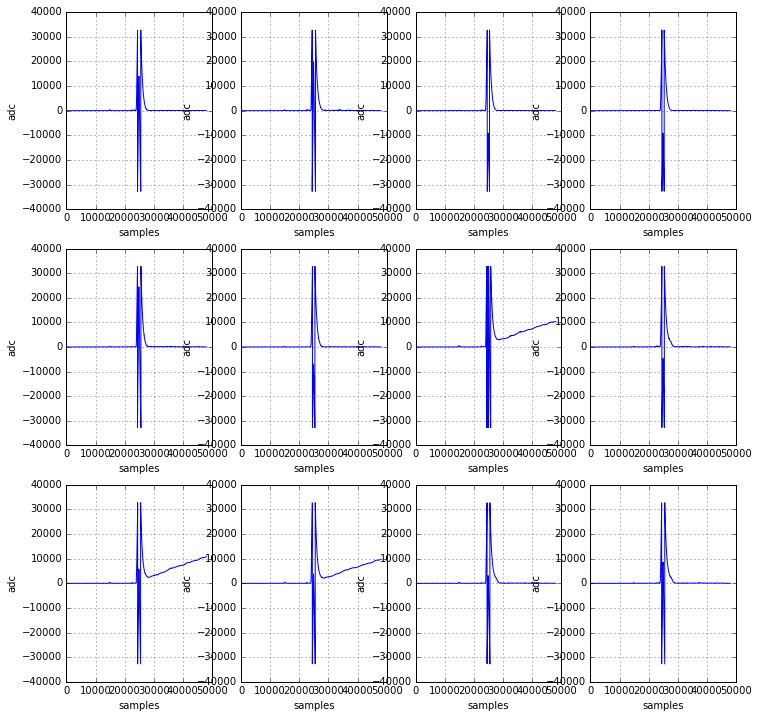

In [45]:
mpl.plot_waveforms(pmtacum[11], maxlen=0, zoom=False, window_size=2500)

In [50]:
CWF,ACUM = deconv_cpmt(pmtrwf, event=11, thr_trigger=5,thr_acum=2000, 
                                 acum_discharge_length = 5000, 
                                 acum_tau=2500, 
                                 acum_compress=0.01)

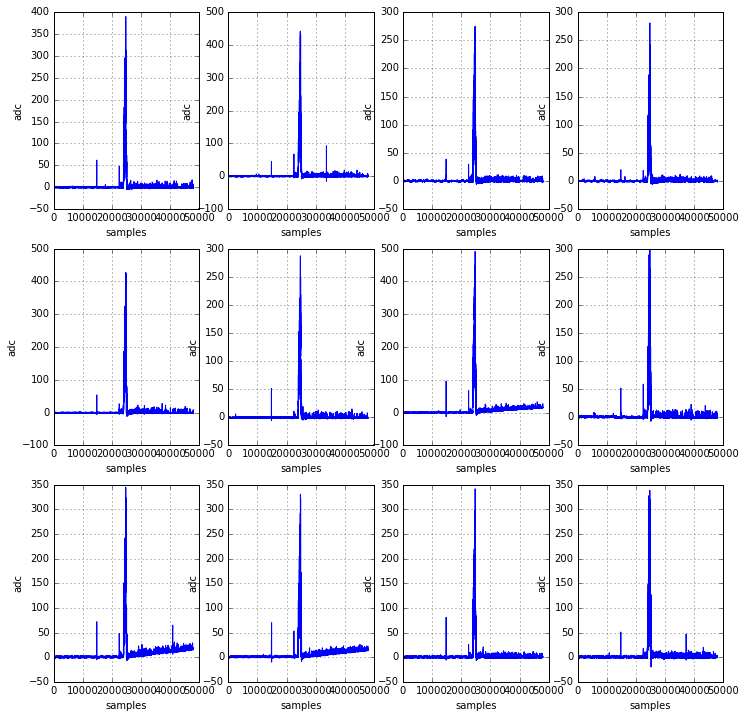

In [52]:
mpl.plot_waveforms(CWF, maxlen=0, zoom=False, window_size=2500)

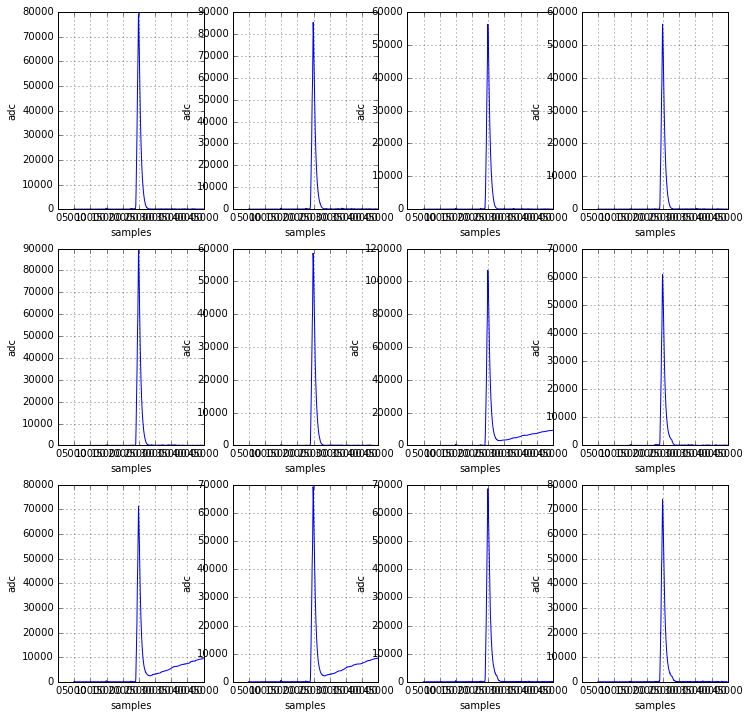

In [55]:
mpl.plot_waveforms(ACUM, maxlen=0, zoom=True, window_size=20000)

In [66]:
CWF,ACUM = deconv_cpmt(pmtrwf, event=11, thr_trigger=5,thr_acum=2500, 
                                 acum_discharge_length = 5000, 
                                 acum_tau=4500, 
                                 acum_compress=0.05)

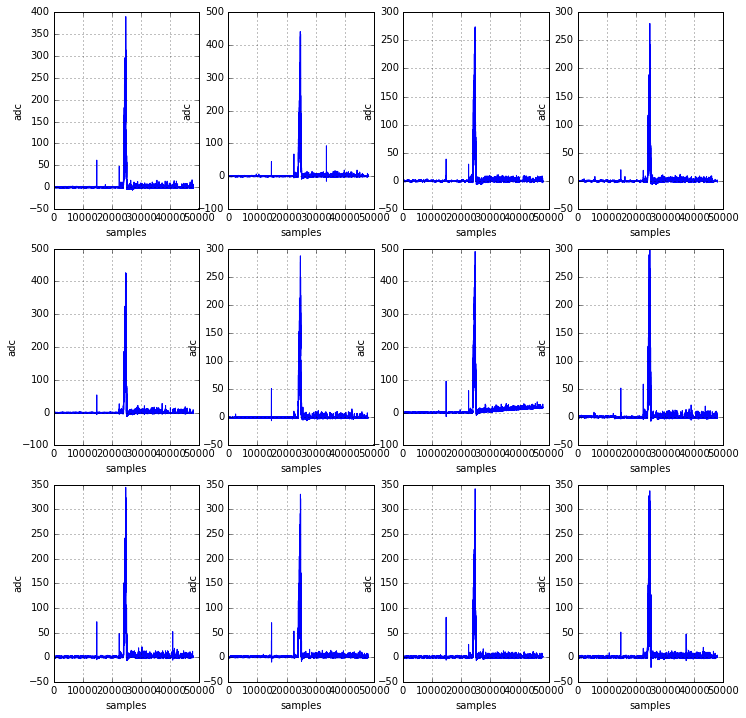

In [67]:
mpl.plot_waveforms(CWF, maxlen=0, zoom=False, window_size=2500)

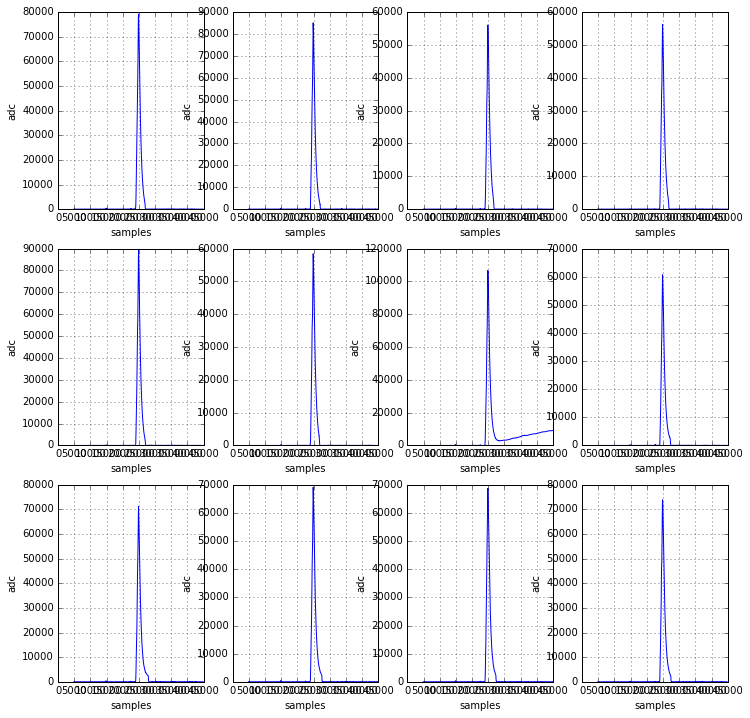

In [68]:
mpl.plot_waveforms(ACUM, maxlen=0, zoom=True, window_size=20000)

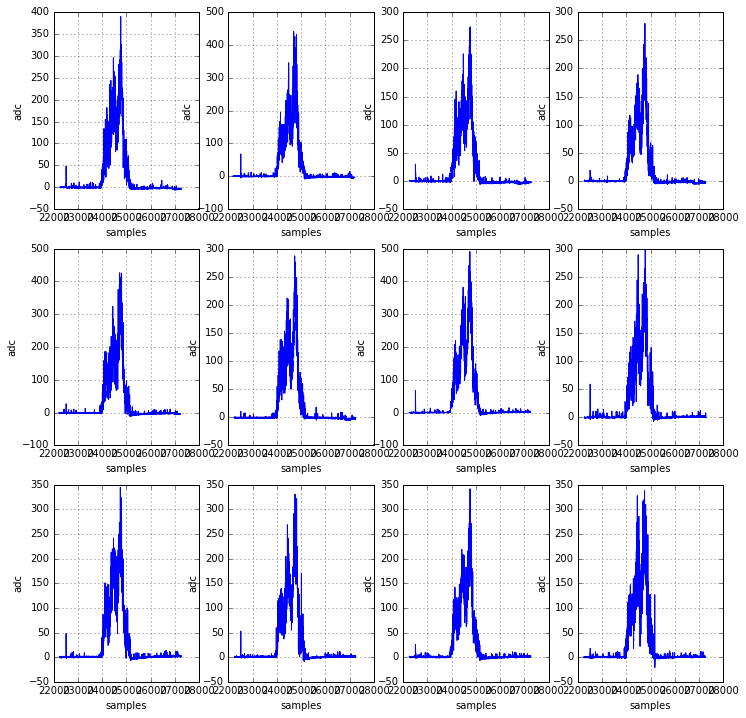

In [69]:
mpl.plot_waveforms(CWF, maxlen=0, zoom=True, window_size=2500)

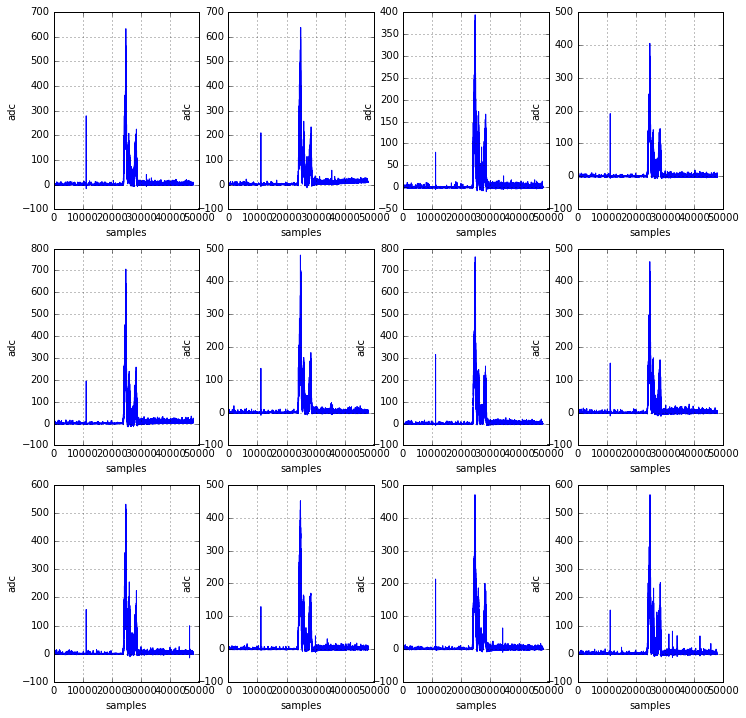

In [70]:
mpl.plot_waveforms(pmtcwf[12], maxlen=0, zoom=False, window_size=2500)

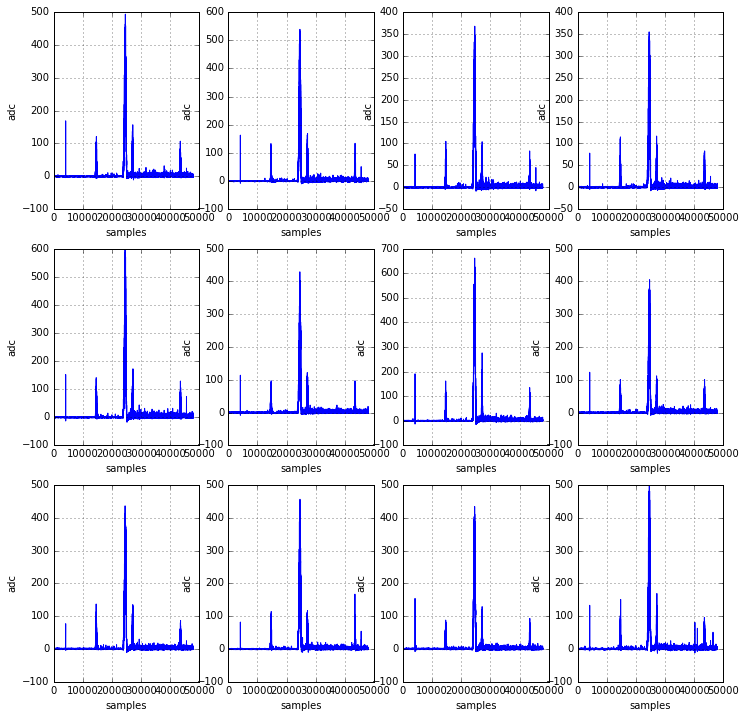

In [71]:
mpl.plot_waveforms(pmtcwf[13], maxlen=0, zoom=False, window_size=2500)

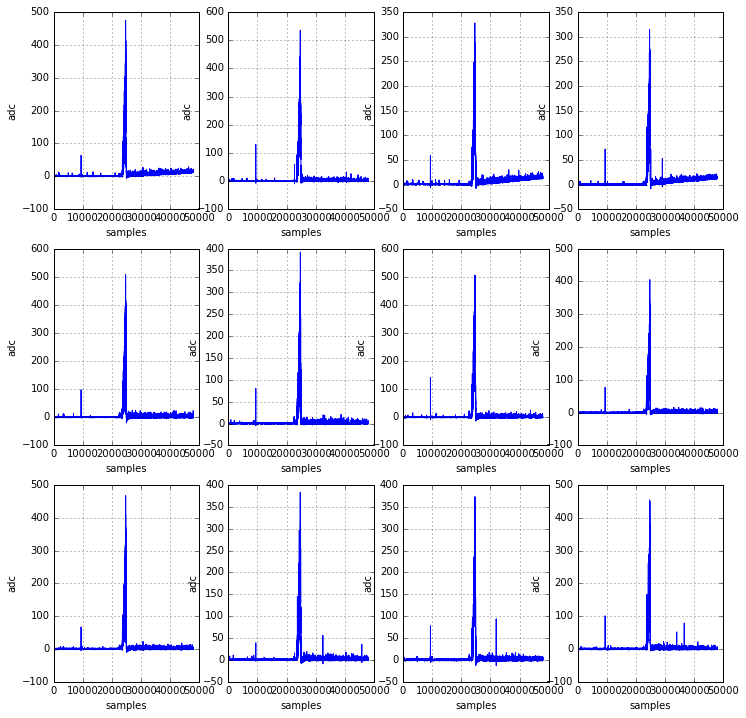

In [72]:
mpl.plot_waveforms(pmtcwf[14], maxlen=0, zoom=False, window_size=2500)

In [73]:
CWF,ACUM = deconv_cpmt(pmtrwf, event=14, thr_trigger=5,thr_acum=2500, 
                                 acum_discharge_length = 5000, 
                                 acum_tau=2500, 
                                 acum_compress=0.05)

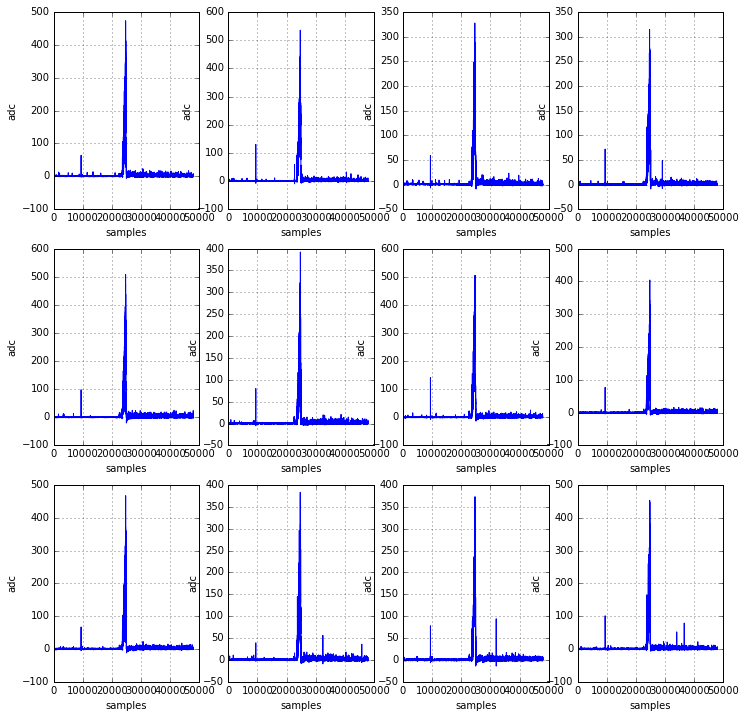

In [74]:
mpl.plot_waveforms(CWF, maxlen=0, zoom=False, window_size=2500)

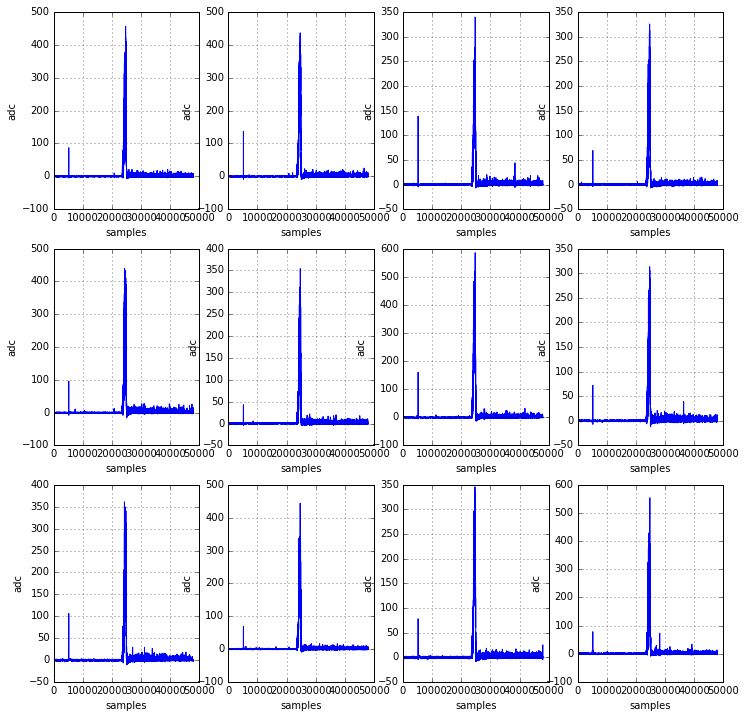

In [75]:
mpl.plot_waveforms(pmtcwf[15], maxlen=0, zoom=False, window_size=2500)

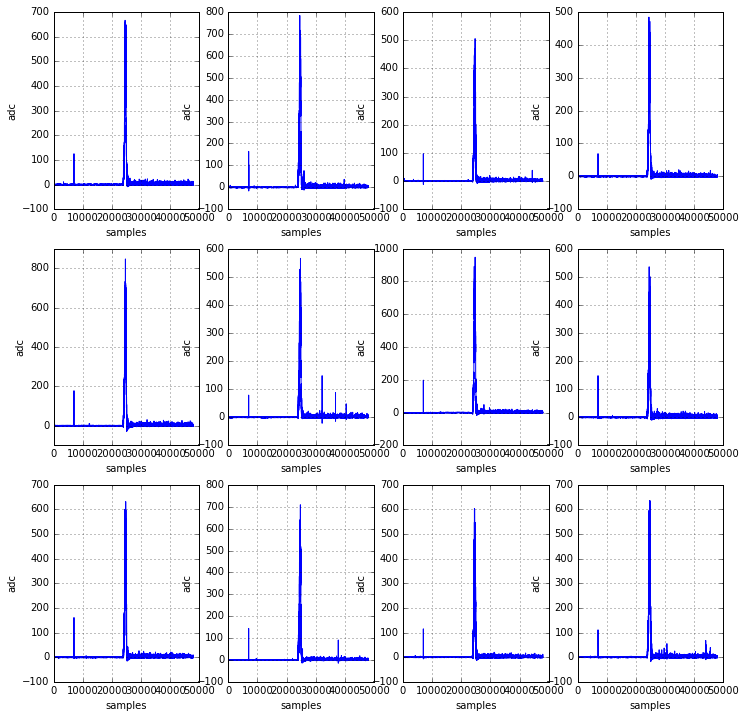

In [76]:
mpl.plot_waveforms(pmtcwf[16], maxlen=0, zoom=False, window_size=2500)

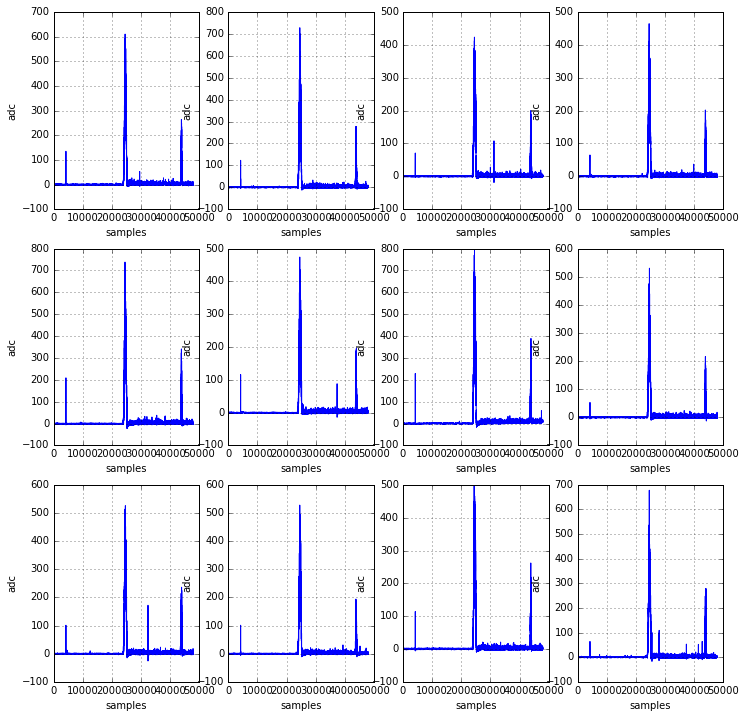

In [77]:
mpl.plot_waveforms(pmtcwf[17], maxlen=0, zoom=False, window_size=2500)

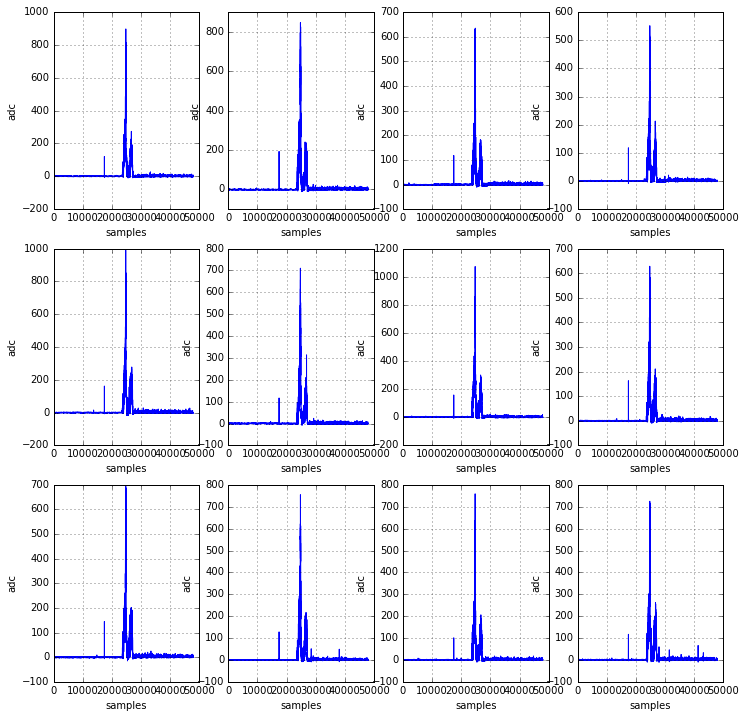

In [78]:
mpl.plot_waveforms(pmtcwf[18], maxlen=0, zoom=False, window_size=2500)

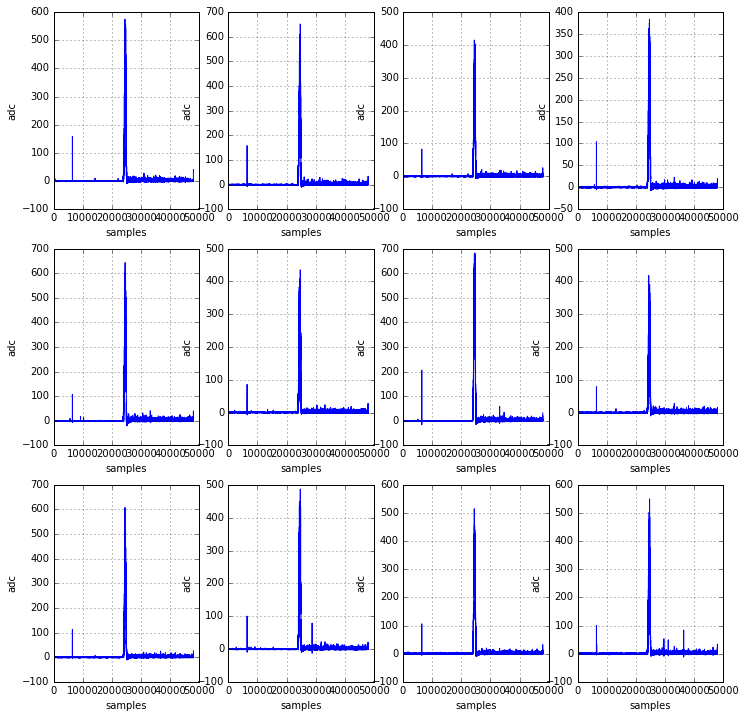

In [79]:
mpl.plot_waveforms(pmtcwf[19], maxlen=0, zoom=False, window_size=2500)

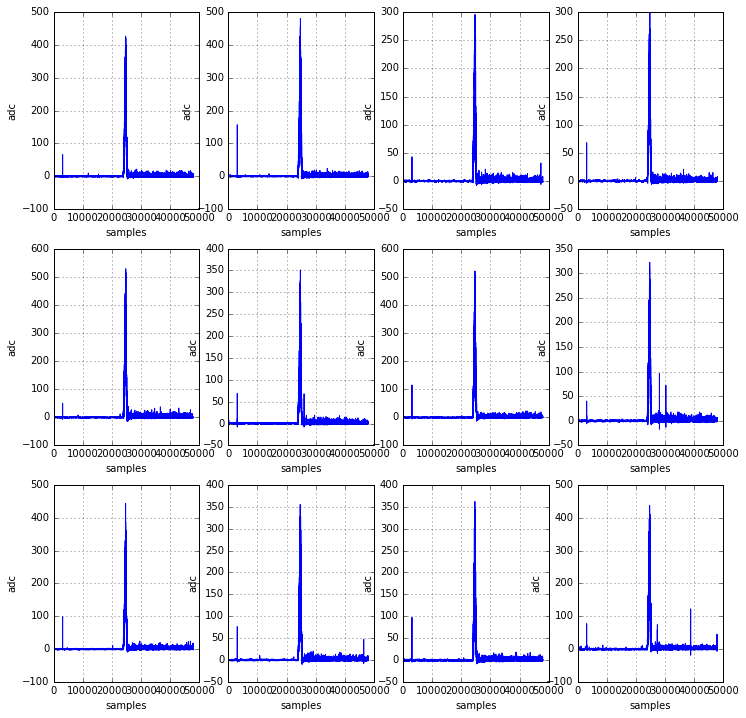

In [80]:
mpl.plot_waveforms(pmtcwf[20], maxlen=0, zoom=False, window_size=2500)

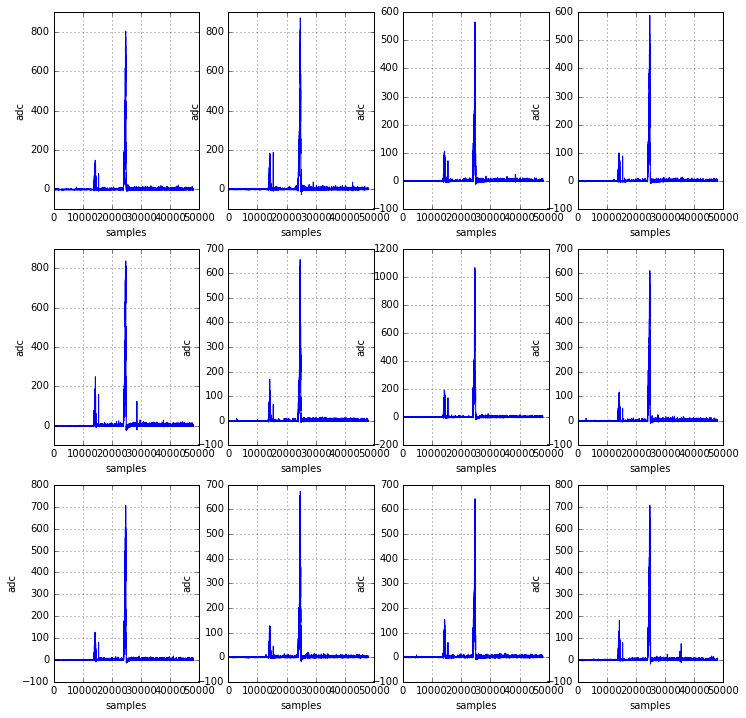

In [81]:
mpl.plot_waveforms(pmtcwf[21], maxlen=0, zoom=False, window_size=2500)

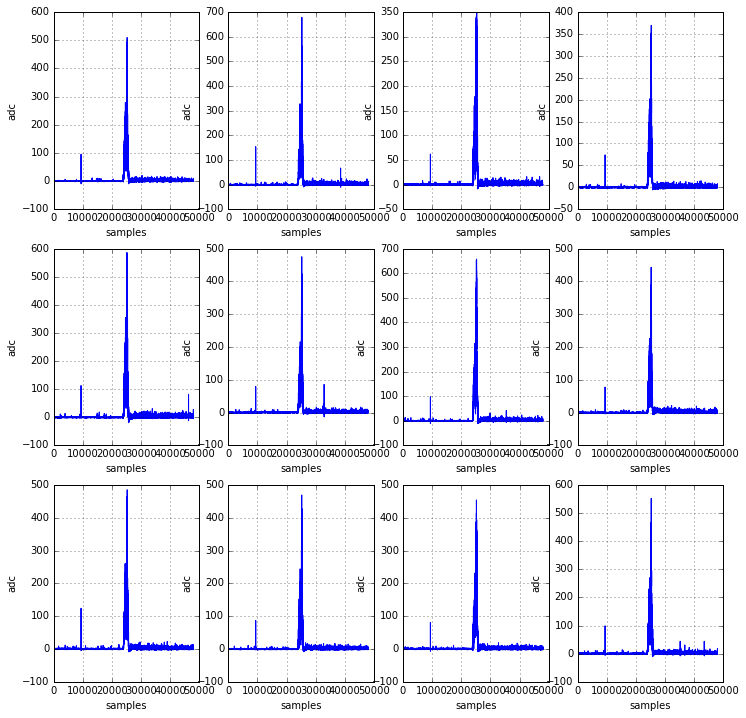

In [82]:
mpl.plot_waveforms(pmtcwf[22], maxlen=0, zoom=False, window_size=2500)

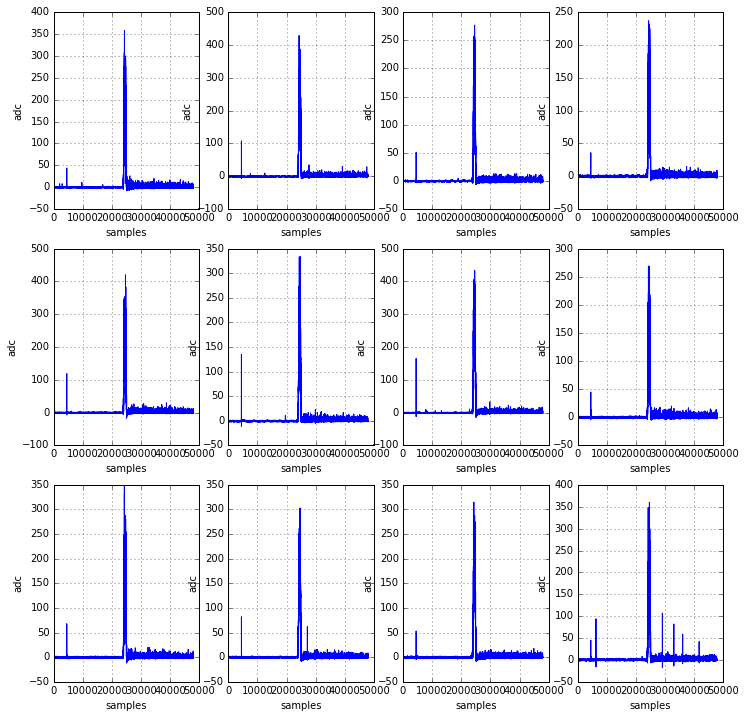

In [83]:
mpl.plot_waveforms(pmtcwf[23], maxlen=0, zoom=False, window_size=2500)

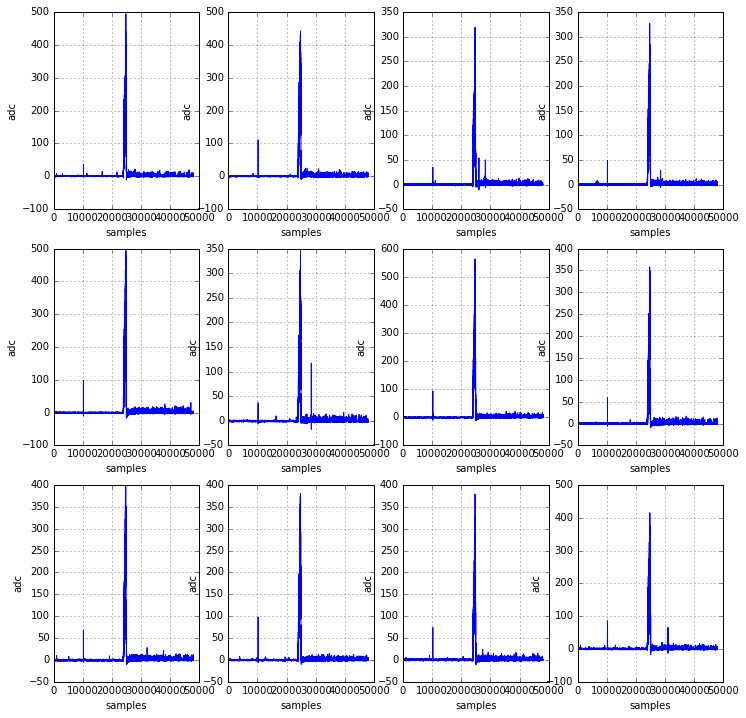

In [84]:
mpl.plot_waveforms(pmtcwf[24], maxlen=0, zoom=False, window_size=2500)

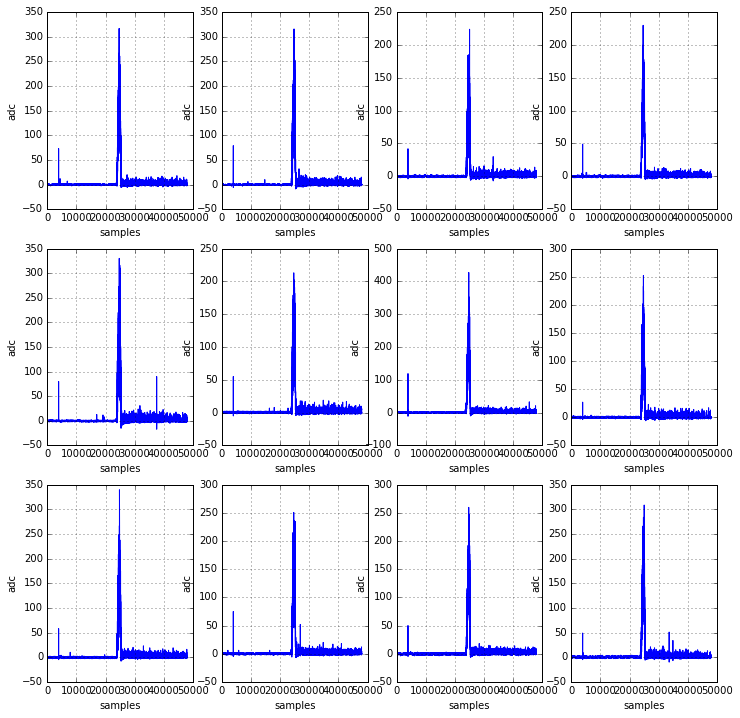

In [85]:
mpl.plot_waveforms(pmtcwf[25], maxlen=0, zoom=False, window_size=2500)

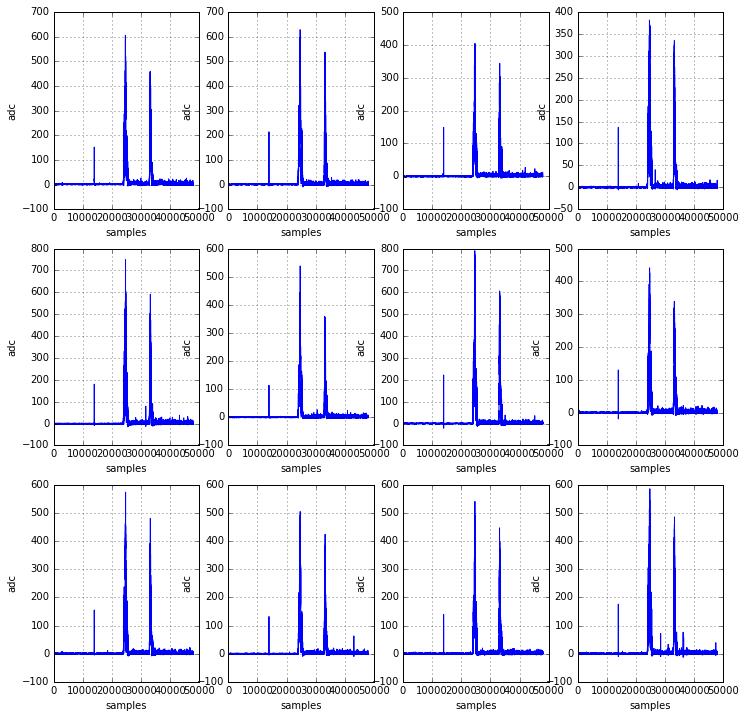

In [86]:
mpl.plot_waveforms(pmtcwf[26], maxlen=0, zoom=False, window_size=2500)

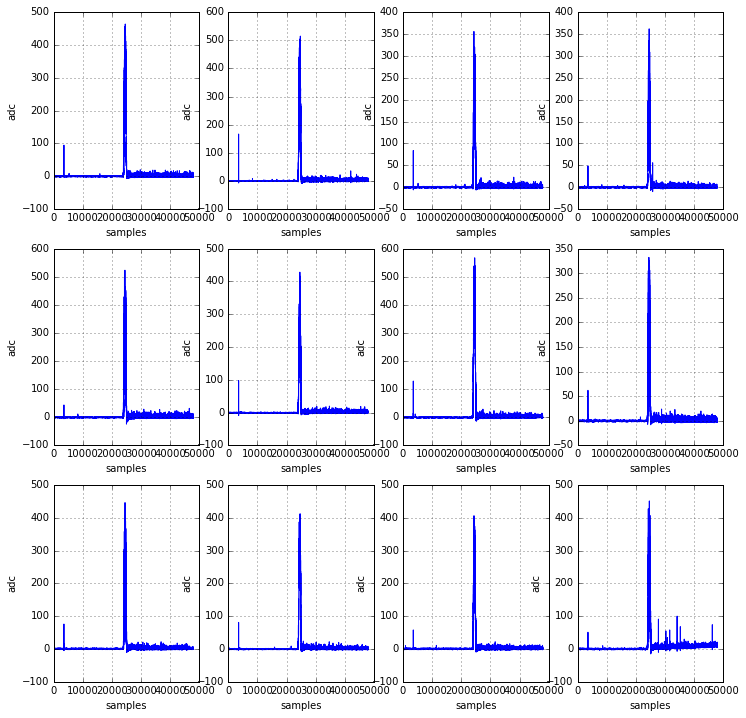

In [87]:
mpl.plot_waveforms(pmtcwf[27], maxlen=0, zoom=False, window_size=2500)

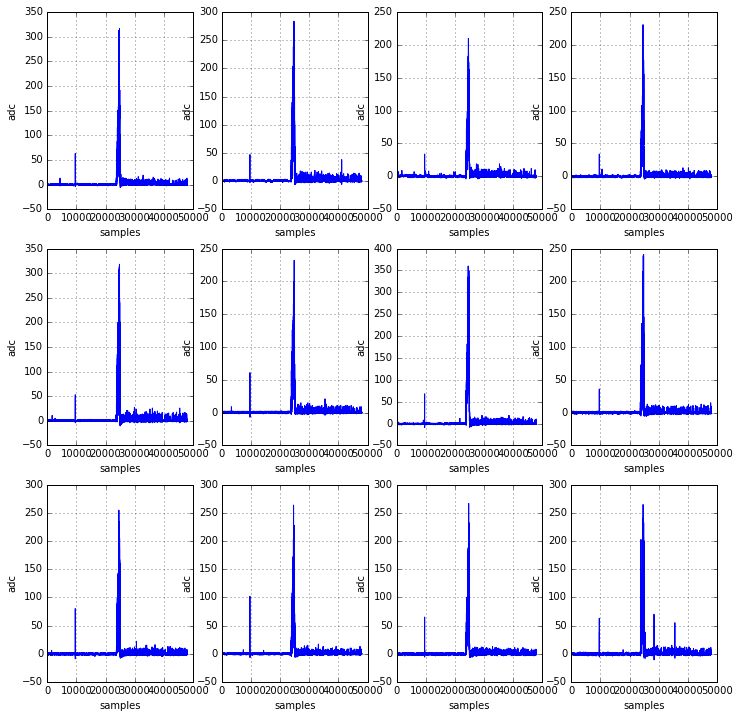

In [88]:
mpl.plot_waveforms(pmtcwf[28], maxlen=0, zoom=False, window_size=2500)

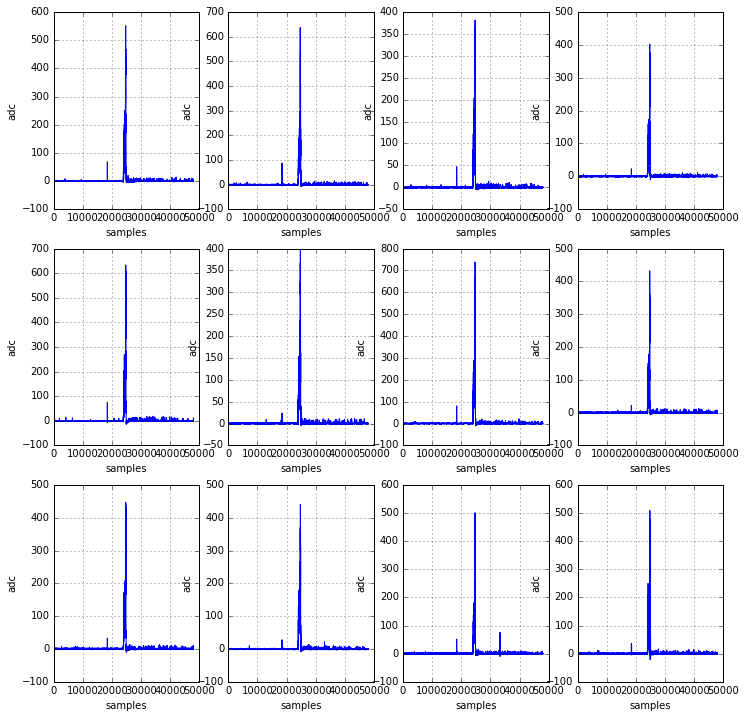

In [89]:
mpl.plot_waveforms(pmtcwf[29], maxlen=0, zoom=False, window_size=2500)

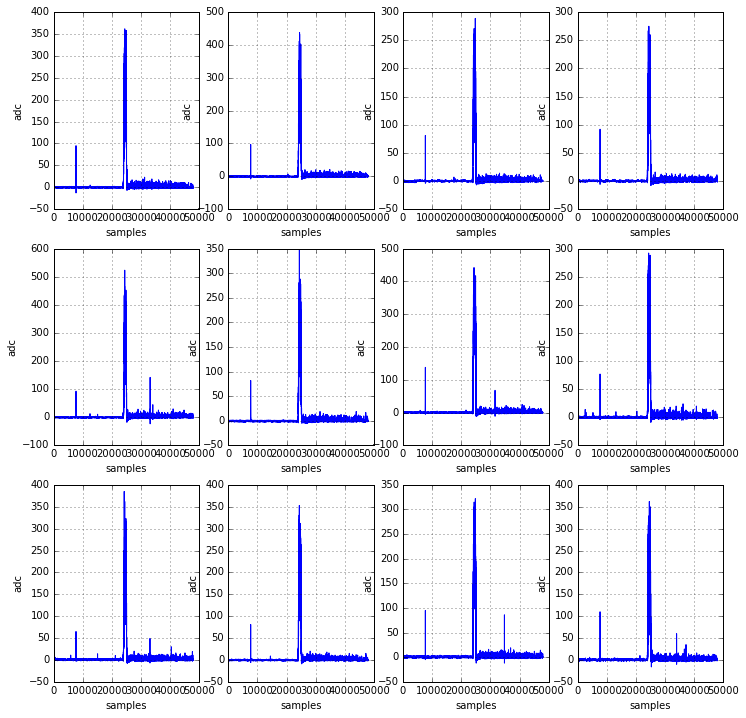

In [90]:
mpl.plot_waveforms(pmtcwf[30], maxlen=0, zoom=False, window_size=2500)

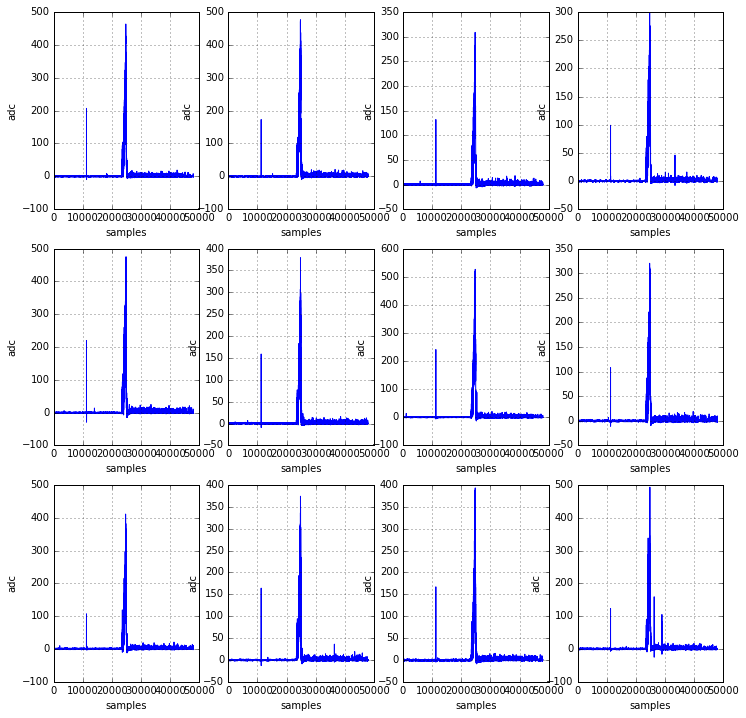

In [91]:
mpl.plot_waveforms(pmtcwf[31], maxlen=0, zoom=False, window_size=2500)

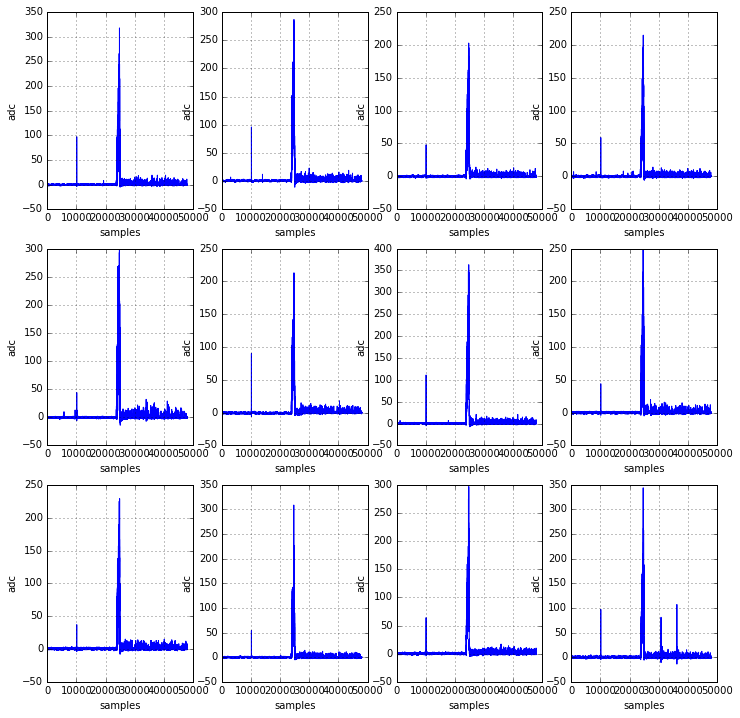

In [92]:
mpl.plot_waveforms(pmtcwf[32], maxlen=0, zoom=False, window_size=2500)

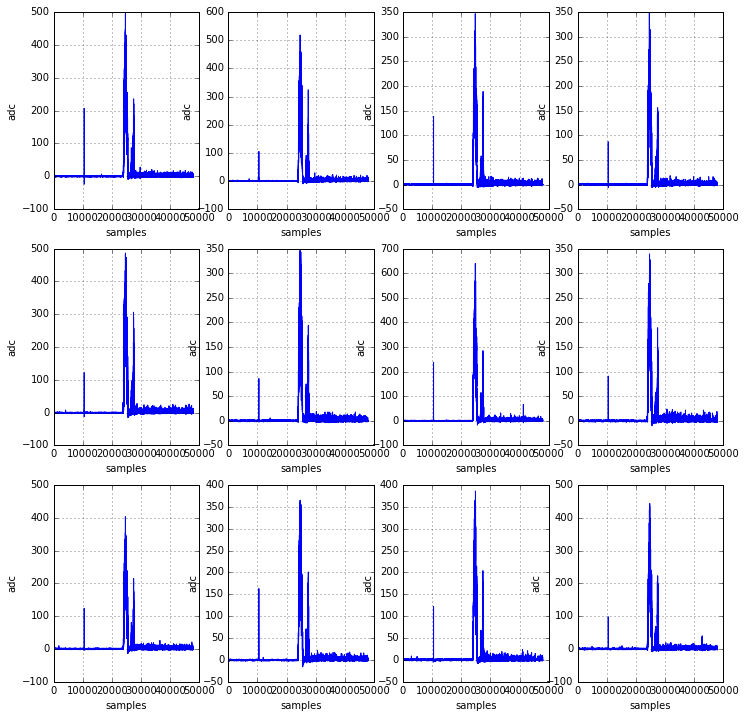

In [93]:
mpl.plot_waveforms(pmtcwf[33], maxlen=0, zoom=False, window_size=2500)

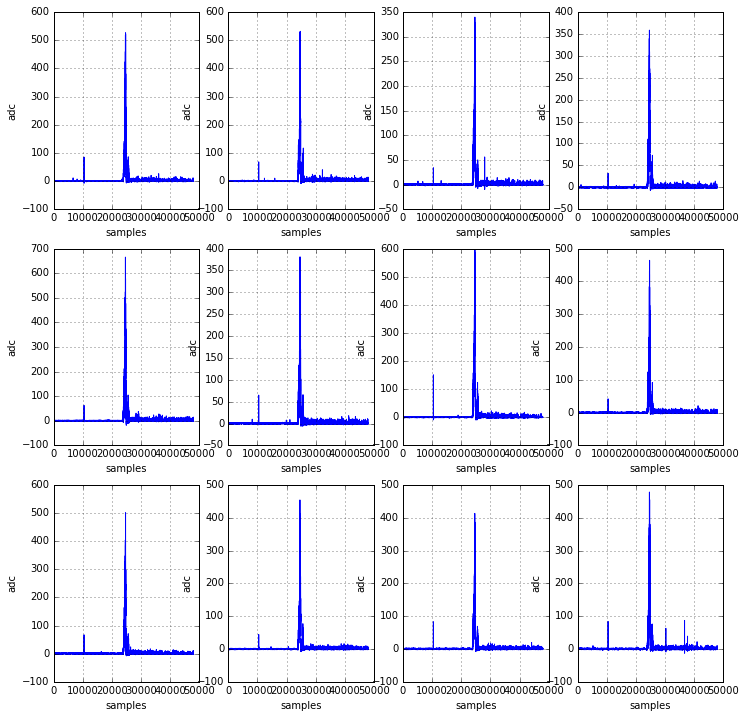

In [94]:
mpl.plot_waveforms(pmtcwf[34], maxlen=0, zoom=False, window_size=2500)

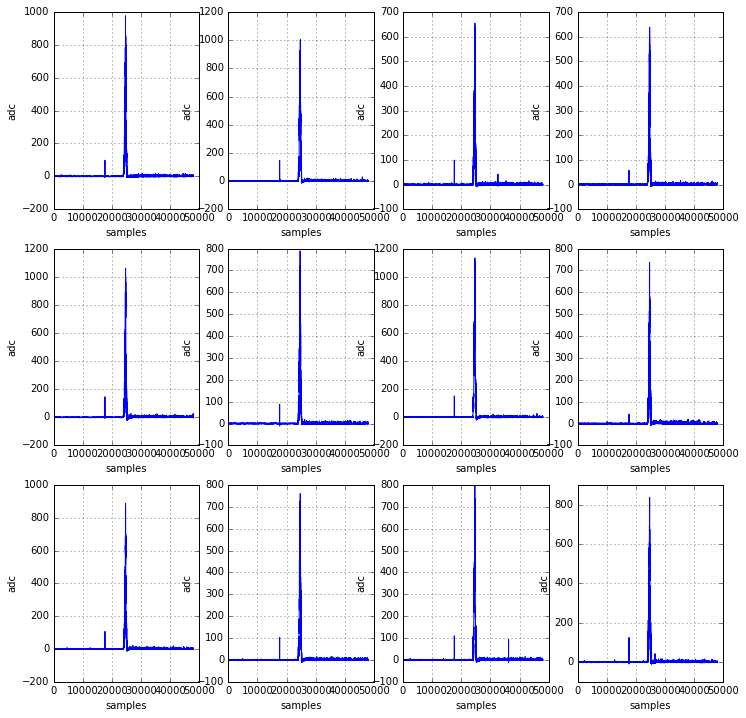

In [95]:
mpl.plot_waveforms(pmtcwf[35], maxlen=0, zoom=False, window_size=2500)

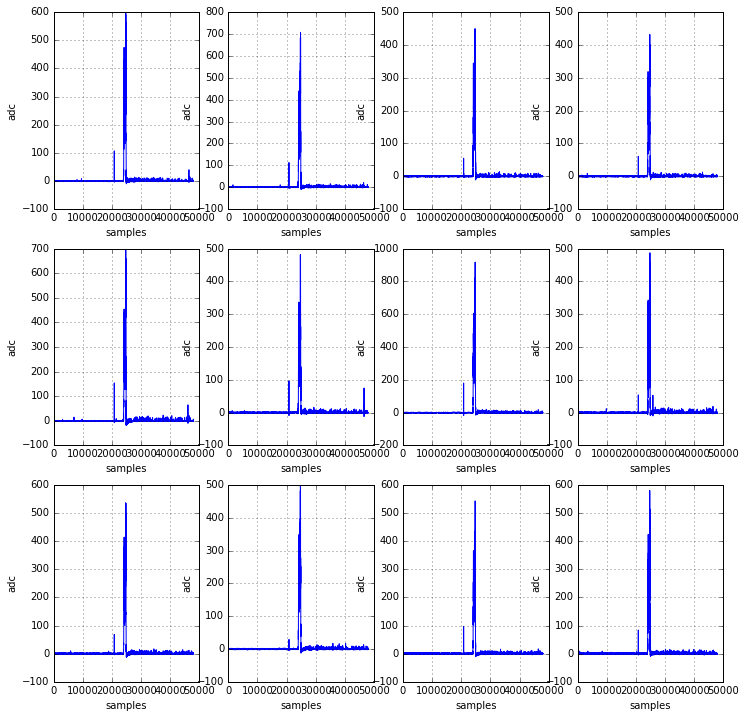

In [96]:
mpl.plot_waveforms(pmtcwf[36], maxlen=0, zoom=False, window_size=2500)

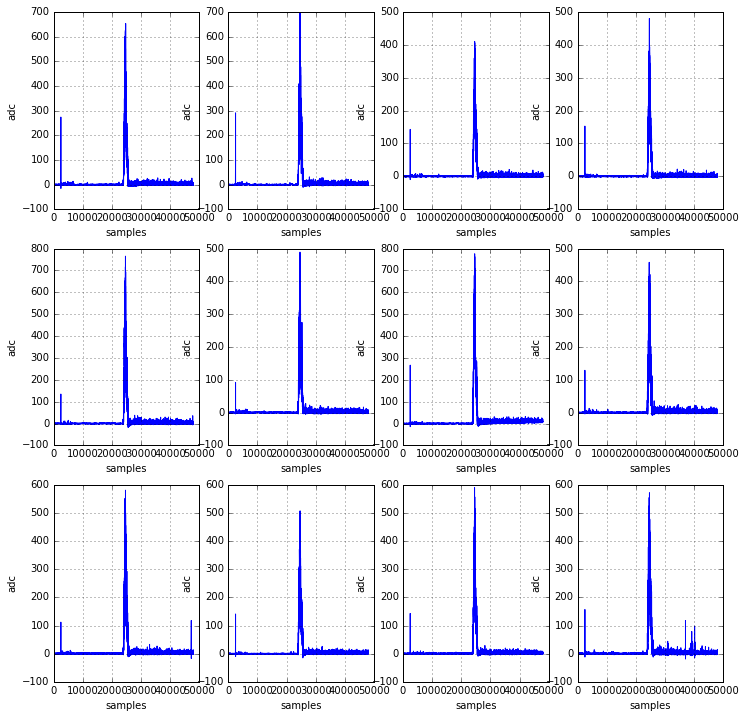

In [97]:
mpl.plot_waveforms(pmtcwf[37], maxlen=0, zoom=False, window_size=2500)

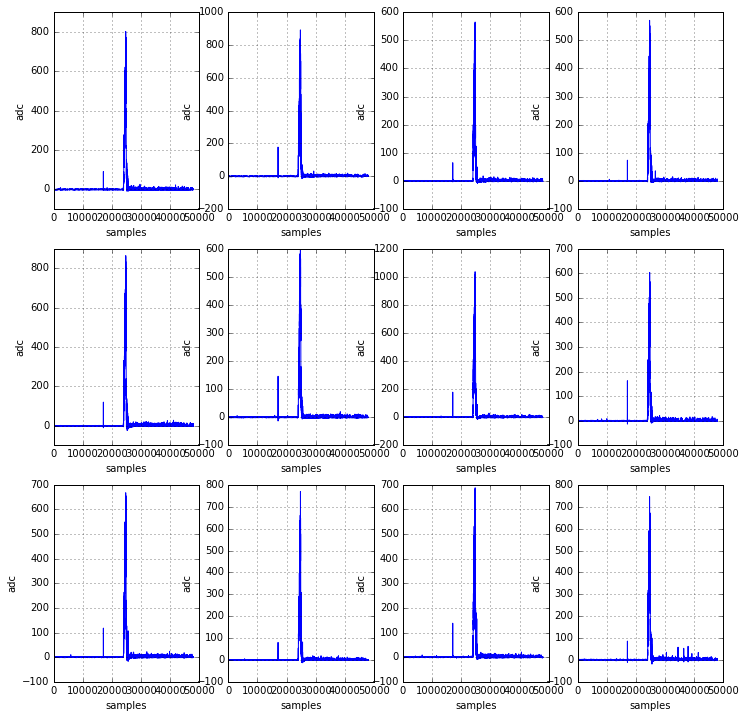

In [98]:
mpl.plot_waveforms(pmtcwf[38], maxlen=0, zoom=False, window_size=2500)

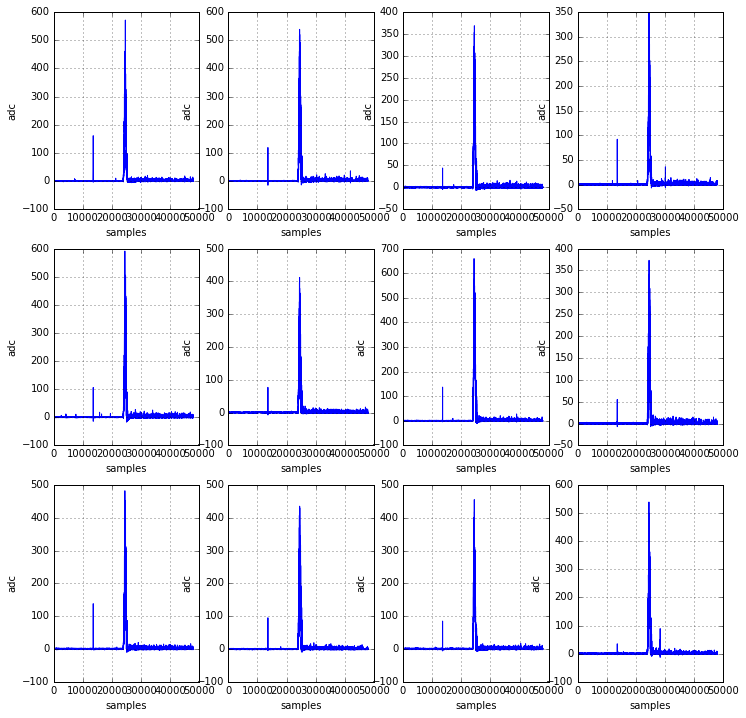

In [99]:
mpl.plot_waveforms(pmtcwf[39], maxlen=0, zoom=False, window_size=2500)

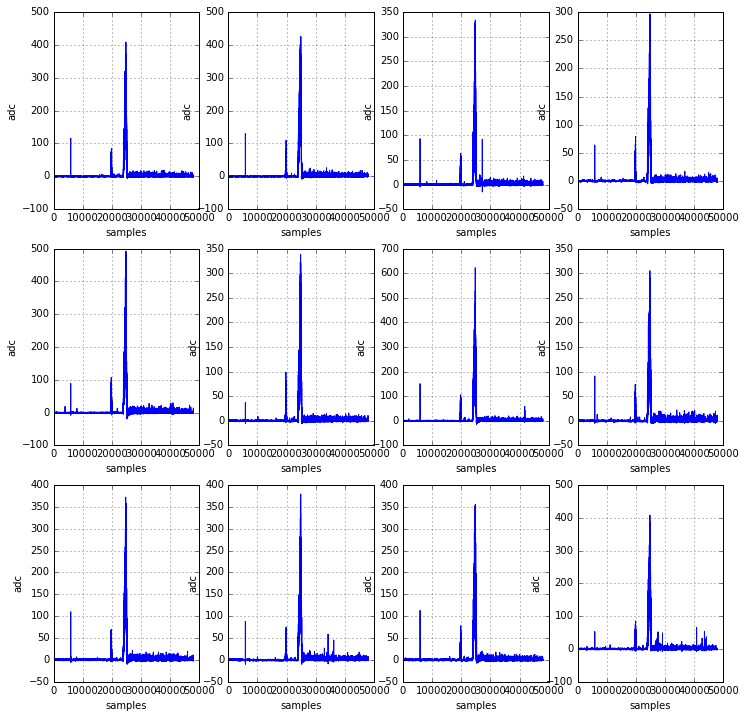

In [100]:
mpl.plot_waveforms(pmtcwf[40], maxlen=0, zoom=False, window_size=2500)

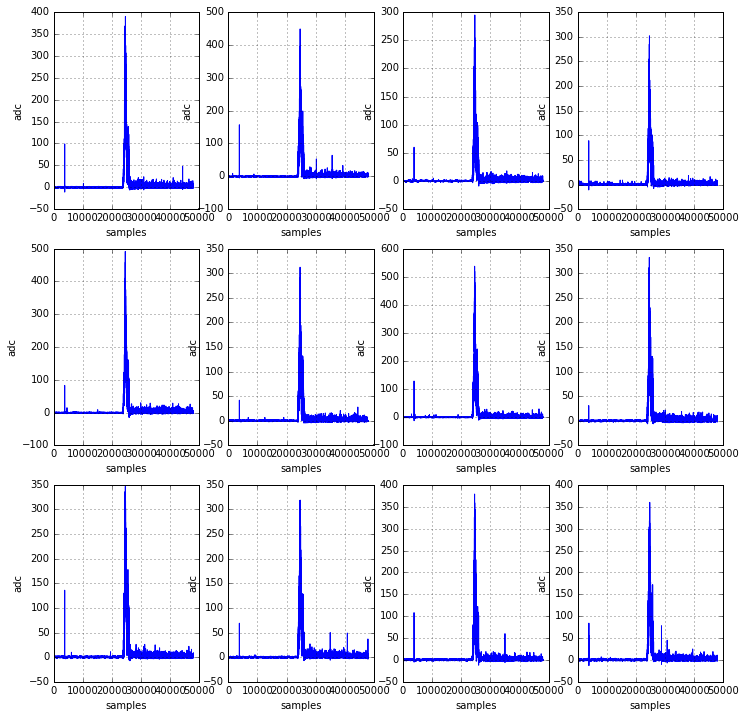

In [101]:
mpl.plot_waveforms(pmtcwf[41], maxlen=0, zoom=False, window_size=2500)

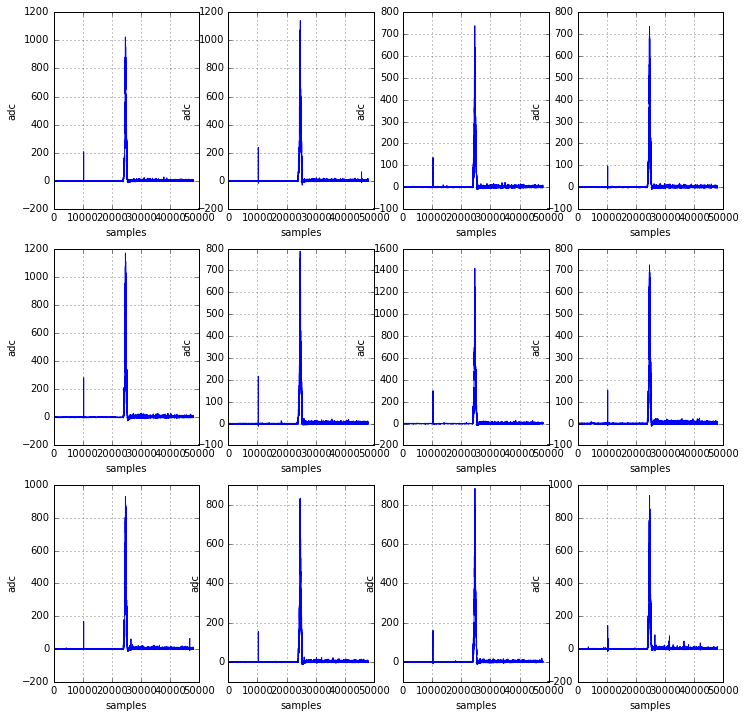

In [102]:
mpl.plot_waveforms(pmtcwf[42], maxlen=0, zoom=False, window_size=2500)

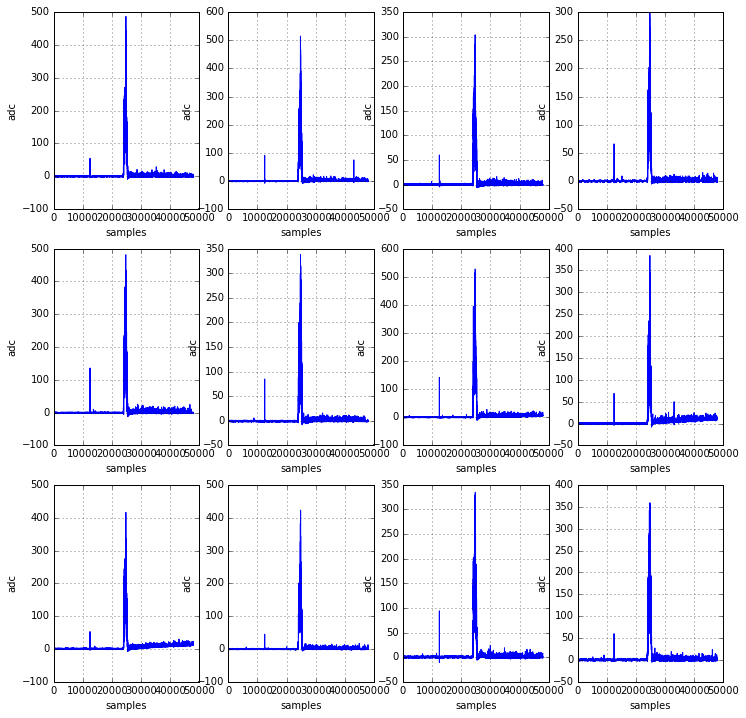

In [103]:
mpl.plot_waveforms(pmtcwf[43], maxlen=0, zoom=False, window_size=2500)

In [105]:
CWF,ACUM = deconv_cpmt(pmtrwf, event=43, thr_trigger=5,thr_acum=2500, 
                                 acum_discharge_length = 5000, 
                                 acum_tau=2500, 
                                 acum_compress=0.05)

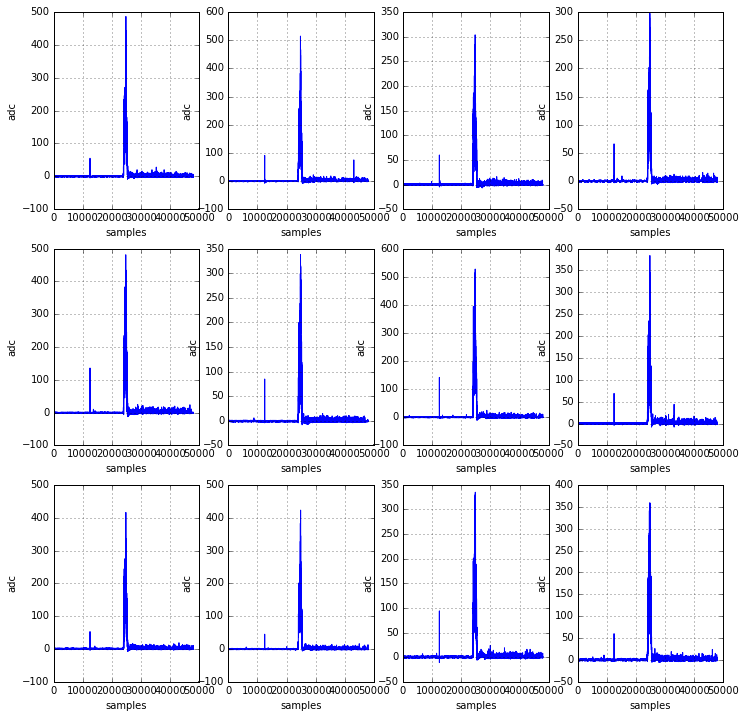

In [106]:
mpl.plot_waveforms(CWF, maxlen=0, zoom=False, window_size=2500)

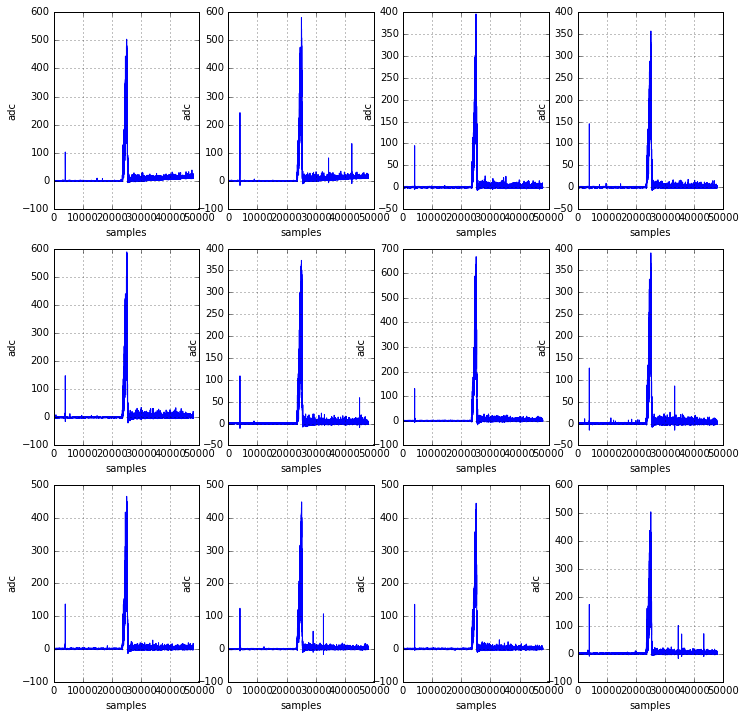

In [104]:
mpl.plot_waveforms(pmtcwf[44], maxlen=0, zoom=False, window_size=2500)

In [107]:
CWF,ACUM = deconv_cpmt(pmtrwf, event=44, thr_trigger=5,thr_acum=2500, 
                                 acum_discharge_length = 5000, 
                                 acum_tau=2500, 
                                 acum_compress=0.05)

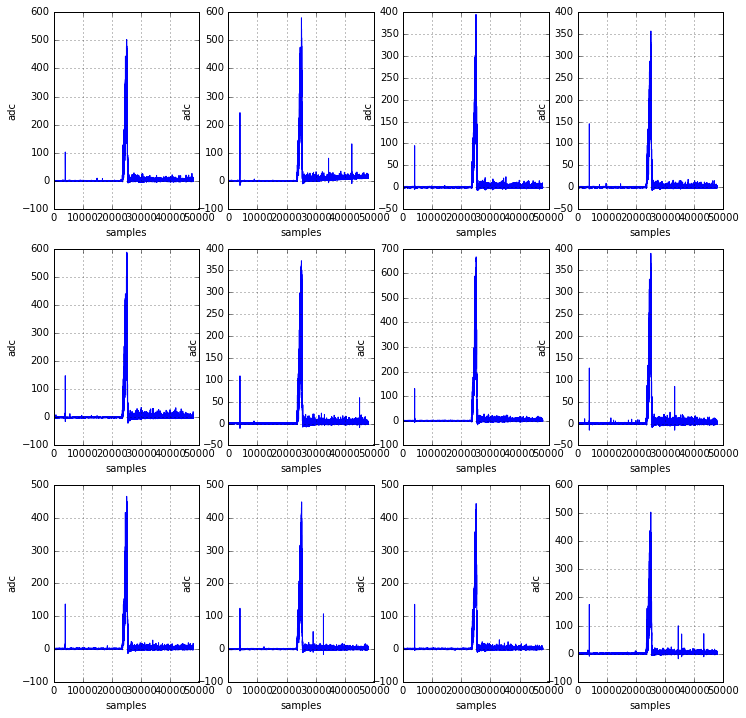

In [108]:
mpl.plot_waveforms(CWF, maxlen=0, zoom=False, window_size=2500)

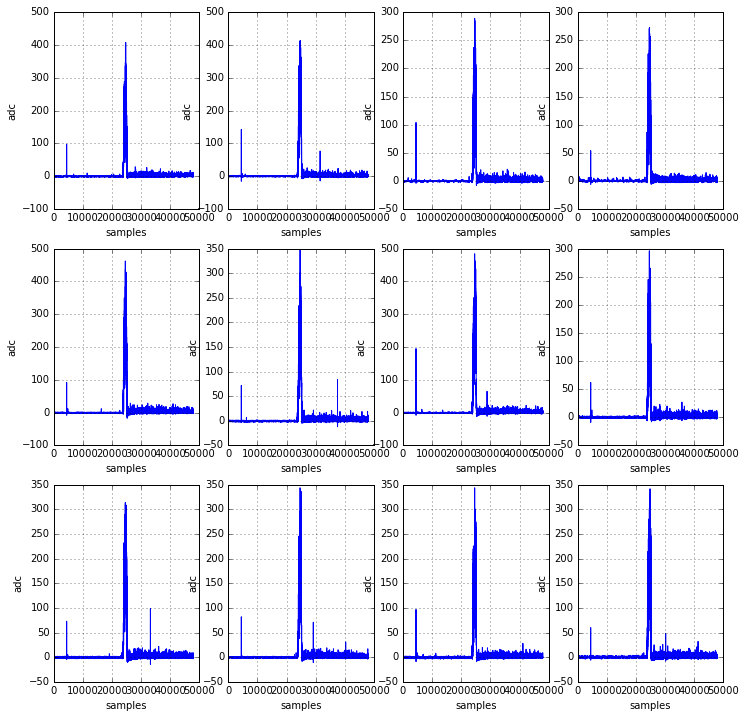

In [109]:
mpl.plot_waveforms(pmtcwf[45], maxlen=0, zoom=False, window_size=2500)

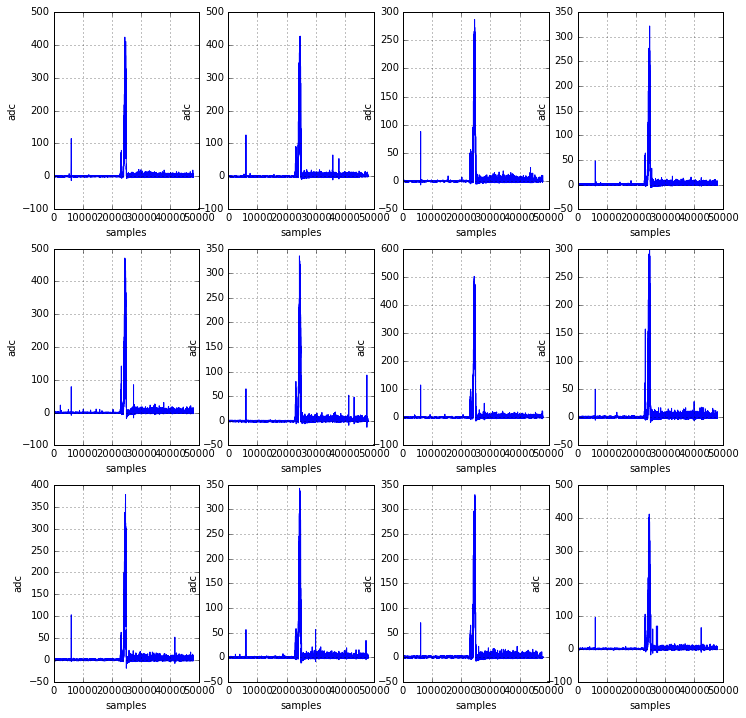

In [110]:
mpl.plot_waveforms(pmtcwf[46], maxlen=0, zoom=False, window_size=2500)

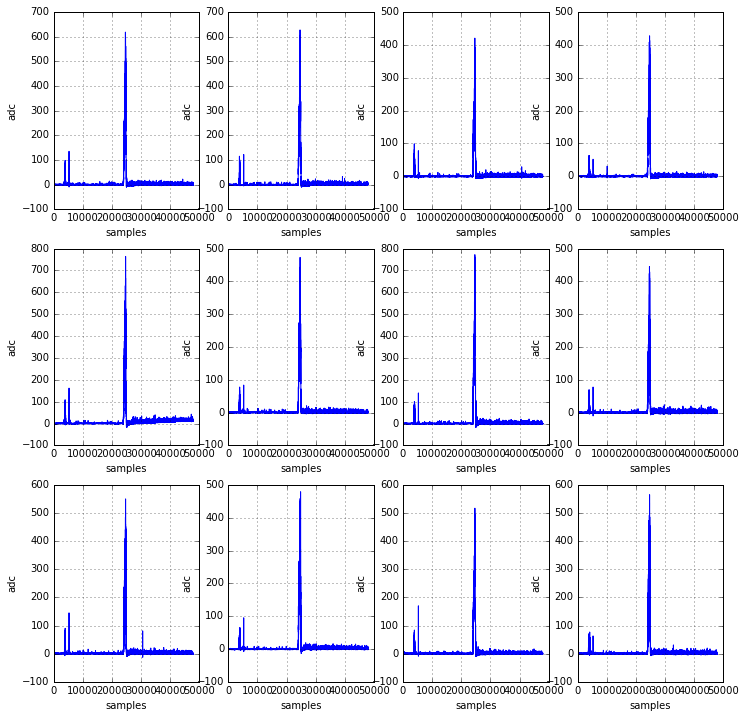

In [111]:
mpl.plot_waveforms(pmtcwf[47], maxlen=0, zoom=False, window_size=2500)

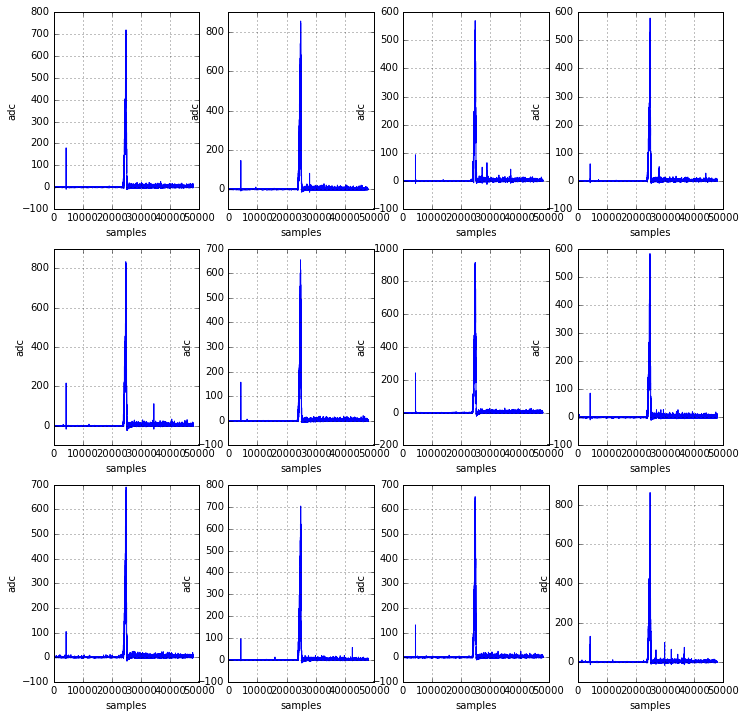

In [112]:
mpl.plot_waveforms(pmtcwf[48], maxlen=0, zoom=False, window_size=2500)

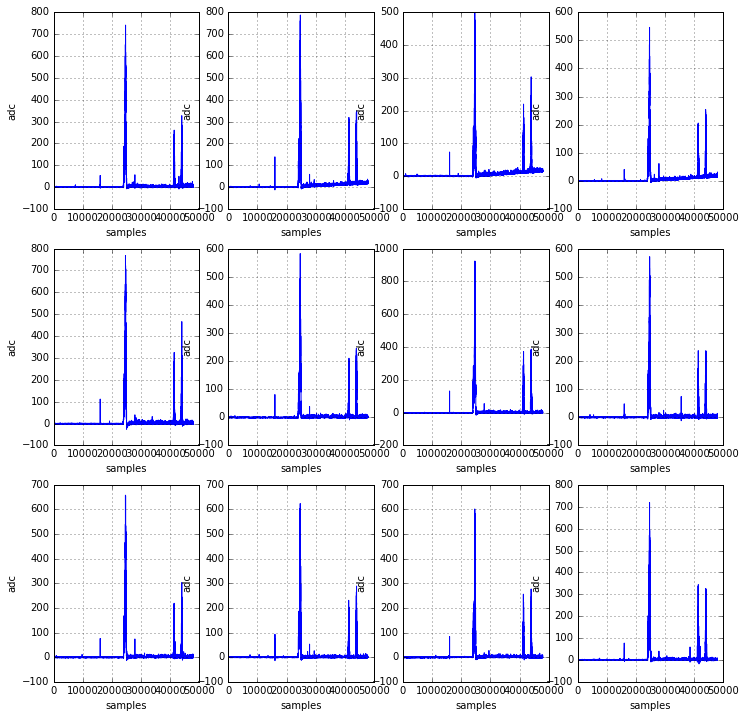

In [113]:
mpl.plot_waveforms(pmtcwf[49], maxlen=0, zoom=False, window_size=2500)

In [131]:
CWF,ACUM = deconv_cpmt(pmtrwf, event=49, thr_trigger=5,thr_acum=4000, 
                                 acum_discharge_length = 5000, 
                                 acum_tau=5000, 
                                 acum_compress=0.05)

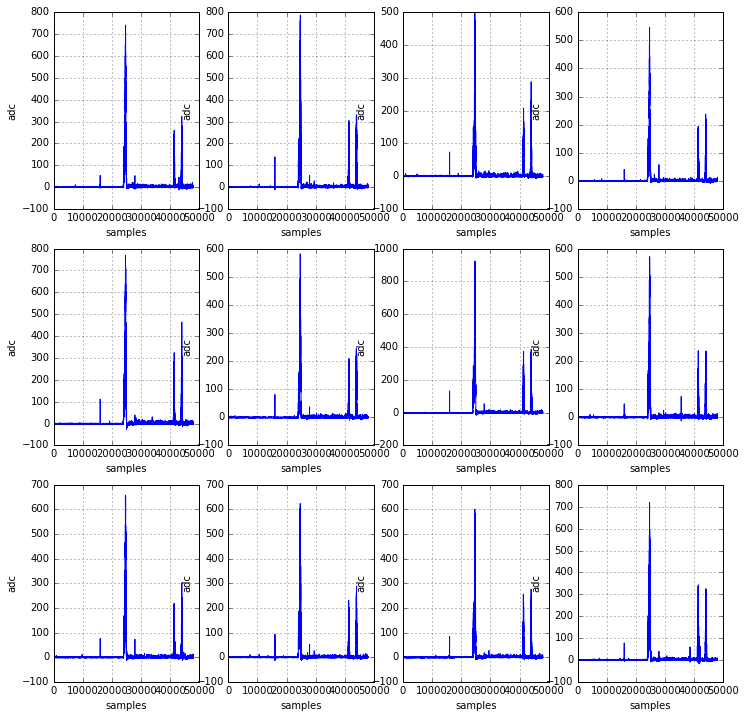

In [132]:
mpl.plot_waveforms(CWF, maxlen=0, zoom=False, window_size=2500)

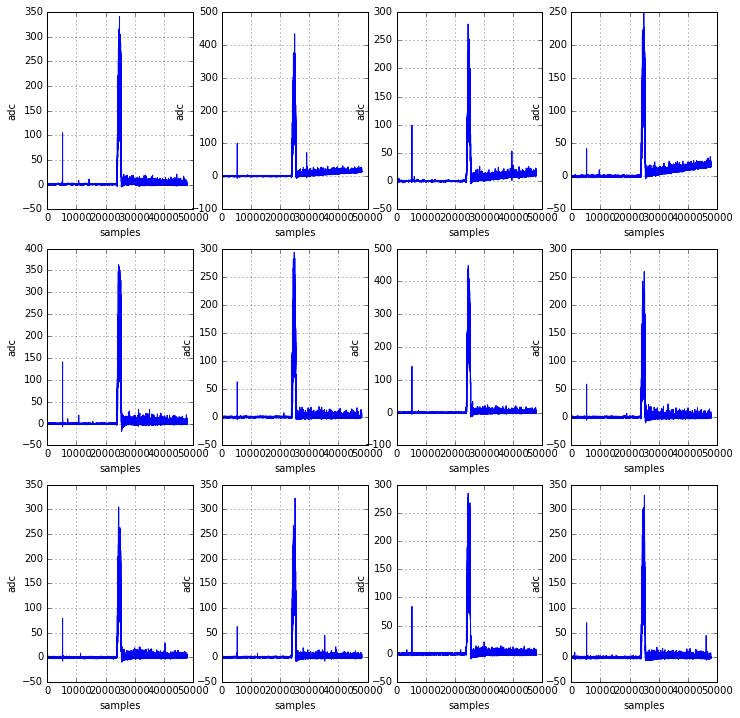

In [118]:
mpl.plot_waveforms(pmtcwf[50], maxlen=0, zoom=False, window_size=2500)

In [129]:
CWF,ACUM = deconv_cpmt(pmtrwf, event=50, thr_trigger=5,thr_acum=4000, 
                                 acum_discharge_length = 5000, 
                                 acum_tau=5000, 
                                 acum_compress=0.05)

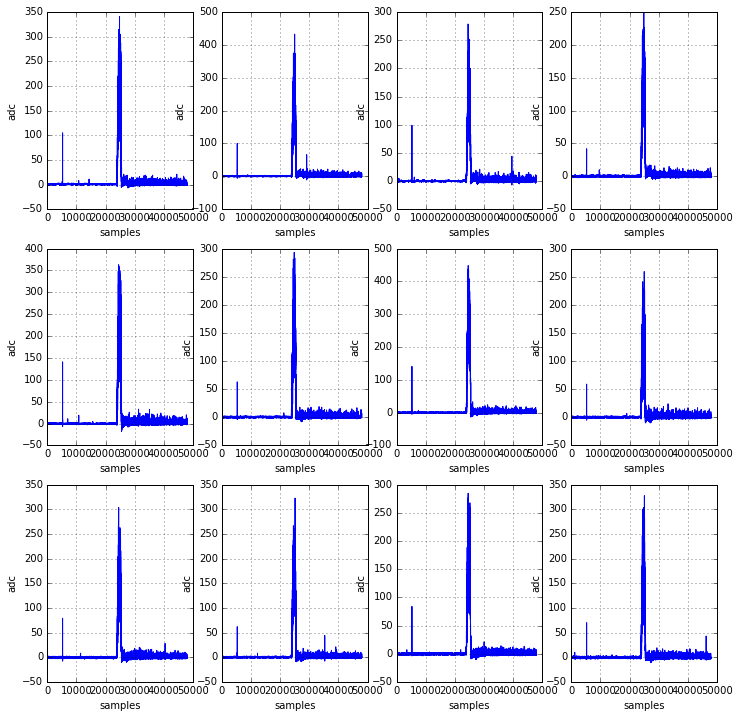

In [130]:
mpl.plot_waveforms(CWF, maxlen=0, zoom=False, window_size=2500)

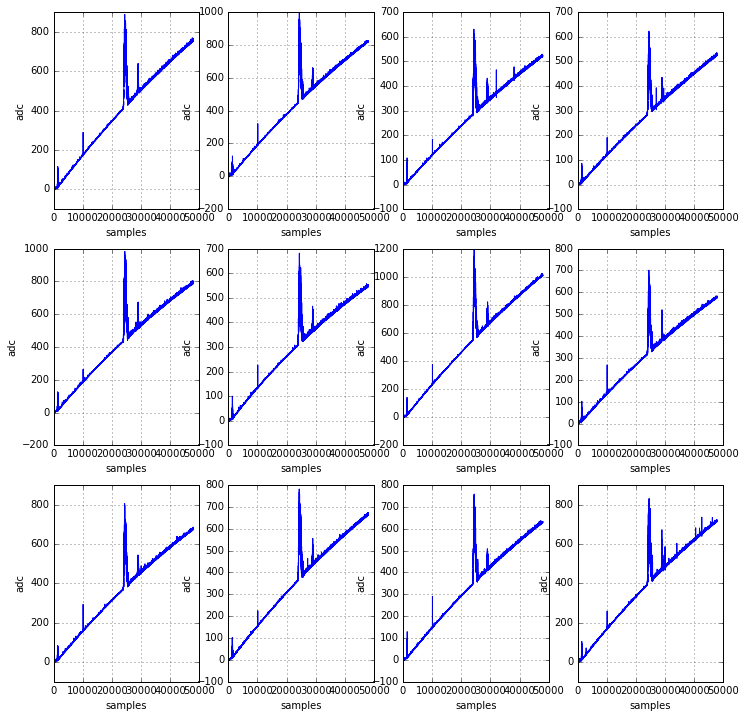

In [150]:
mpl.plot_waveforms(pmtcwf[65], maxlen=0, zoom=False, window_size=800)

In [151]:
CWF,ACUM = deconv_cpmt(pmtrwf, event=65, thr_trigger=5,thr_acum=4000, 
                                 acum_discharge_length = 5000, 
                                 acum_tau=5000, 
                                 acum_compress=0.05)

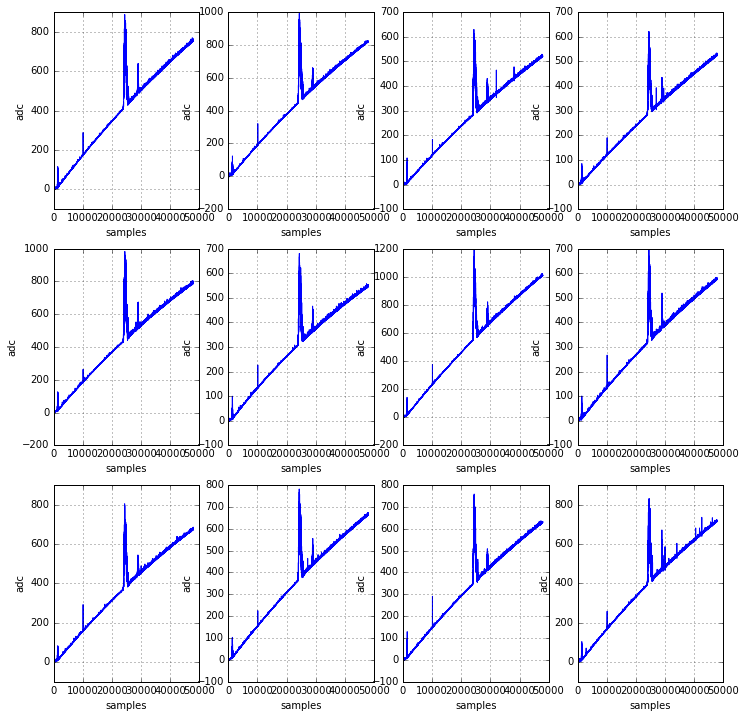

In [152]:
mpl.plot_waveforms(CWF, maxlen=0, zoom=False, window_size=2500)

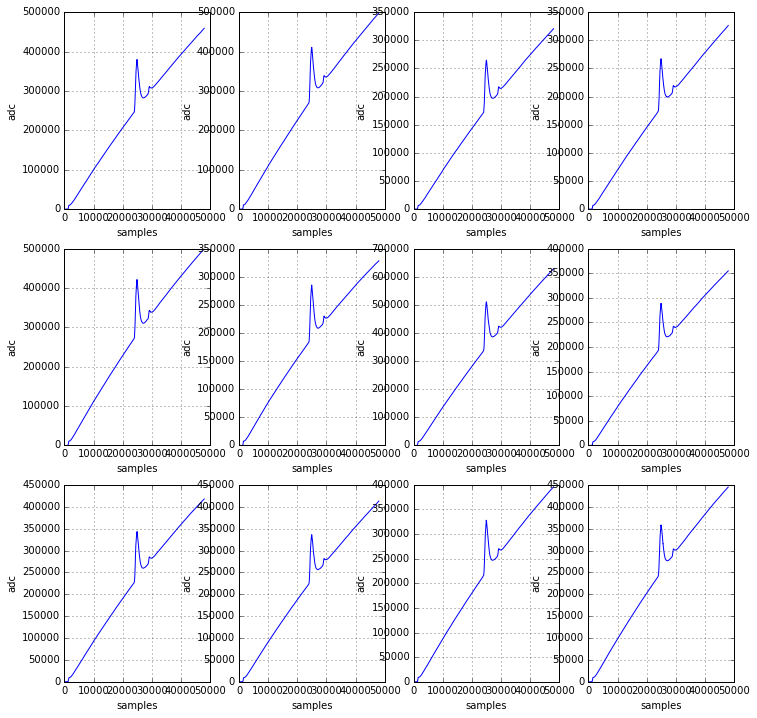

In [153]:
mpl.plot_waveforms(ACUM, maxlen=0, zoom=False, window_size=2500)

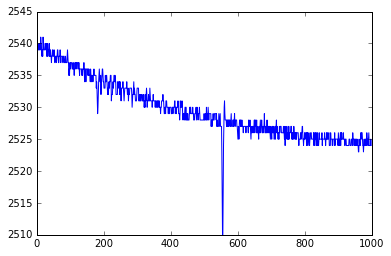

In [190]:
plt.plot(range(0,1000), pmtrwf[65,1][0:1000])

In [188]:
cwf = CWF[1]

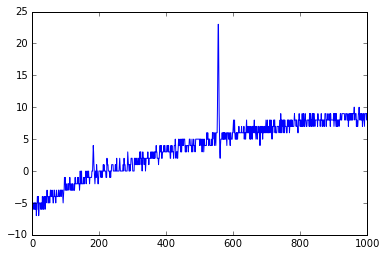

In [189]:
plt.plot(range(0,1000), cwf[0:1000])

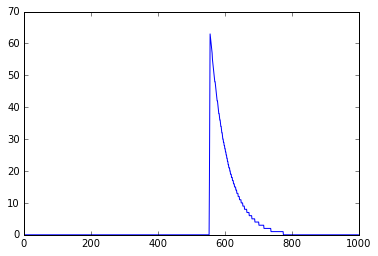

In [186]:
plt.plot(range(0,1000), acum[0:1000])

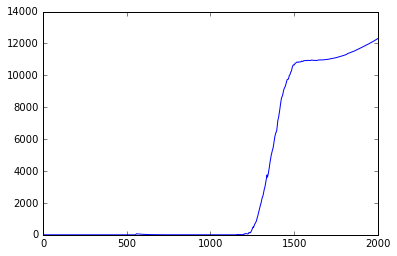

In [193]:
plt.plot(range(0,2000), acum[0:2000])

In [163]:
np.mean(pmtrwf[65,0][0:500])

2532.8780000000002

In [164]:
signal_i = 2532.89 - pmtrwf[65,0]

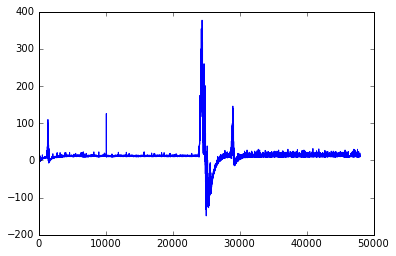

In [166]:
plt.plot(signal_i)

In [184]:
acum = ACUM[1]

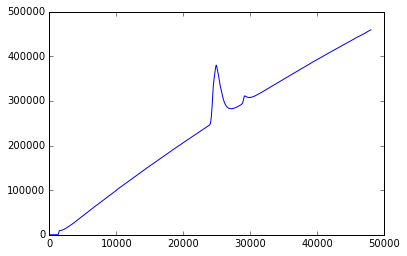

In [169]:
plt.plot(acum)

In [157]:
mpl.plot_waveforms(pmtrwf[65,1], maxlen=0, zoom=False, window_size=2500)

TypeError: object of type 'numpy.int16' has no len()